# Application of a PiNN on the Mackey Glass time series
# (when only the initial condition and parameters are specified)

# Combined Bachelor Thesis (NS-320B), June 2022
## Mathematics & Physics and Astronomy
*'Applying Physics-informed Neural Networks to Chaotic Systems of Ordinary Differential Equations'*

**Author:** Martijn Sebastiaan Brouwer (6859488)

**Mathematics supervisors:** prof. dr. ir. C.W. Oosterlee

**Physics supervisor:** dr. J. de Graaf

**PhD supervisor:** B. Negyesi

## Making directories and importing packages

In [3]:
!mkdir plots_x

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(12345)
np.random.seed(12345)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

mkdir: cannot create directory ‘plots_x’: File exists
Not connected to a GPU


## Definitions 
### (Fully Connected Network (FCN), Runge-Kutta fourth order method, plotting and saving animated gifs)

In [4]:
# ----------------------------------------------------------------------------- 
# -------------------------- Fully Connected Network --------------------------
# ----------------------------------------------------------------------------- 
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going through the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# ----------------------------------------------------------------------------- 
# ----------- Runge-Kutta fourth order method (adapted for MG) ---------------- 
# ----------------------------------------------------------------------------- 
def RungeKutta(dxdt, x0, tf, n): # Specify derivatives, initial conditions and time
    h = tf/n   #Stepsize
    xl = n*[0] #Create lists for output
    xl[0] = x0 #First element in outputlist is initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x_t = xl[i-1]
        if i-1 >= n/tf*tau:
            x_t_minus_tau = xl[int(i-1-n/tf*tau)]
        else: 
            x_t_minus_tau = 0

        #Going through the four RK4 equations:
        k1x = h*dxdt(x_t, x_t_minus_tau)
        xs  = x_t + 0.5*k1x
        xs_minus_tau = x_t_minus_tau + 0.5*k1x
        k2x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + 0.5*k2x  
        xs_minus_tau = x_t_minus_tau + 0.5*k2x
        k3x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + k3x
        xs_minus_tau = x_t_minus_tau + k3x
        k4x = h*dxdt(xs, xs_minus_tau)
        #Update last next value in output list:
        xl[i] = x_t + (k1x + 2*k2x + 2*k3x + k4x)/6 
    return xl


# ----------------------------------------------------------------------------- 
# -------------- 2D plot of RK4 approximation and PINN prediction ------------- 
# ----------------------------------------------------------------------------- 
def plot2D(T,X1,tf, t,pred, init, axis):
    plt.figure()
    plt.plot(T[:int((tf+3)*100)], X1[:int((tf+3)*100)], color="grey", linewidth=2, alpha=0.8, label="RK4 approximation")
    plt.plot(t, pred, color="tab:blue", linewidth=2, alpha=0.6, label="PiNN prediction")
    plt.scatter(t[0],init, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.annotate("Training step: %i"%(i+1),xy=(1.05, 0.87),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss1: {:.2e}".format(loss1),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss2: {:.2e}".format(loss2),xy=(1.05, 0.67),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Learning rate: %.0E"%(lr),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN),xy=(1.05, 0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Optimizer: Adam",xy=(1.05, 0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.1f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1f}".format(tf, alpha, update_t),xy=(1.05, -0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('${}$'.format(axis), fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")

# ----------------------------------------------------------------------------- 
# -------------------------- Creating GIF animations -------------------------- 
# ----------------------------------------------------------------------------- 
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


## Parameters of the Mackey Glass time series and the PiNN

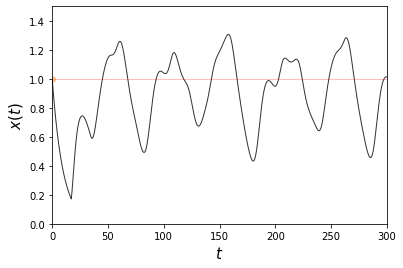

In [32]:
# ----------------------------------------------------------------------------- 
# ----------------- Mackey Glass time series parameters ----------------------- 
# ----------------------------------------------------------------------------- 
x0 = 1               #Initial conditions
a,b,tau = 0.2,0.1,17 #Parameters of the system
ti = 0               #Initial time
tf = 80              #Starting final time (without update)
n = 1000             #Steps taken between ti and tf
h = tf/n             #Step size of each step of n

# ----------------------------------------------------------------------------- 
# ------------------------------ PiNN parameters ------------------------------ 
# ----------------------------------------------------------------------------- 
lr = 1e-3            #Learning rate
INPUT = 1            #Amount of inputs
N_HIDDEN = 32        #Amount of hidden layers
N_LAYERS = 3         #Amount of neurons in hidden layers
OUTPUT = 1           #Amount of outputs
alpha = 0.0000001         #Threshold value for updating tf with update_t
update_t = 5         #Update value for tf after reaching threshold
iterations = 2000000 #Total amount of iterations
intermediate = 2500  #Safe intermediate results after every {intermediate} iterations

# ----------------------------------------------------------------------------- 
# ------------------- Mackey Glass differential equation ---------------------- 
# ----------------------------------------------------------------------------- 
def MG(x_t, x_t_minus_tau):
    return a*x_t_minus_tau/(1 + x_t_minus_tau**10) - b*x_t

# ----------------------------------------------------------------------------- 
# ------------------ Plot of the Mackey Glass time series --------------------- 
# ----------------------------------------------------------------------------- 
x = RungeKutta(MG, x0, 300, n)
t = np.linspace(ti,300,n)
plt.figure()
plt.plot(t, x, color="black", linewidth=1, alpha=0.8)
plt.scatter(0, x0, color="tab:orange", alpha=0.4)
plt.axhline(1, color='r', lw=.5, alpha=.5)
plt.xlabel("$t$", fontsize=15)
plt.ylabel("$x(t)$", fontsize=15)
plt.xlim(0,300)
plt.ylim(0,1.5)
plt.savefig('MG.png')
plt.show()

## The Physics-informed Neural Network

PiNN, iteration: 2500, loss1: 1.6118306120915804e-06, loss2: 0.00039193249540403485, time: 1:35:17.416848


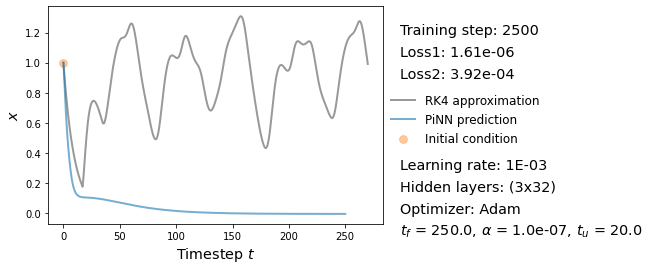

PiNN, iteration: 5000, loss1: 1.5076295767357806e-06, loss2: 0.00038520165253430605, time: 1:35:28.975639


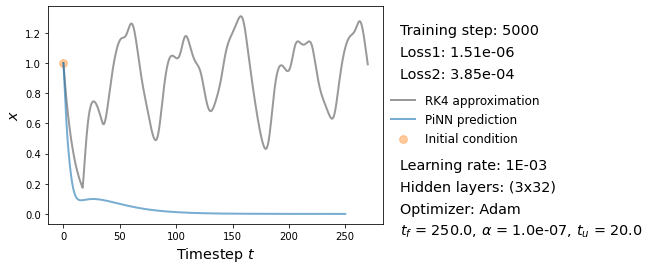

PiNN, iteration: 7500, loss1: 0.0015758274821564555, loss2: 0.0003833820519503206, time: 1:35:39.031794


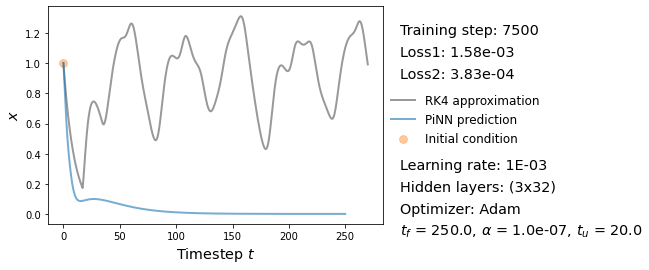

PiNN, iteration: 10000, loss1: 2.476099325576797e-06, loss2: 0.0003809559275396168, time: 1:35:48.974404


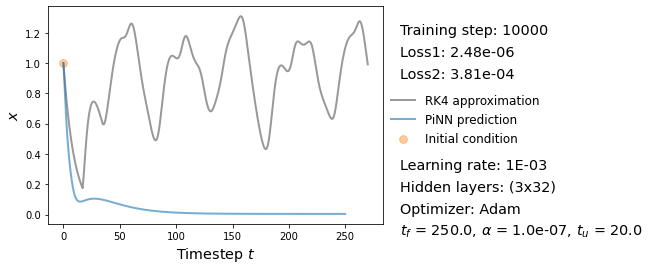

PiNN, iteration: 12500, loss1: 0.13767872750759125, loss2: 0.0003792506468016654, time: 1:35:58.626896


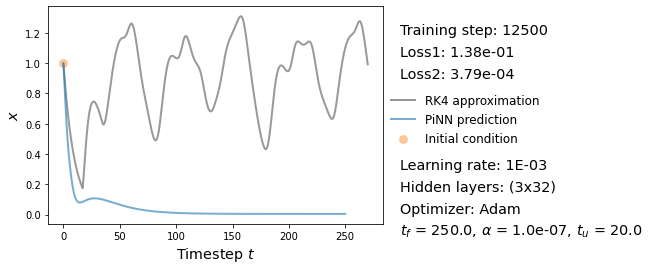

PiNN, iteration: 15000, loss1: 3.769074101001024e-05, loss2: 0.0003762401465792209, time: 1:36:07.479182


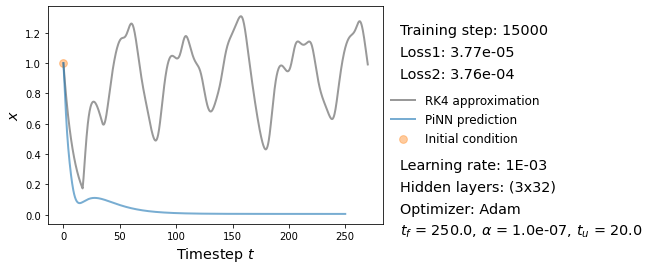

PiNN, iteration: 17500, loss1: 0.001812681439332664, loss2: 0.00037433922989293933, time: 1:36:16.380559


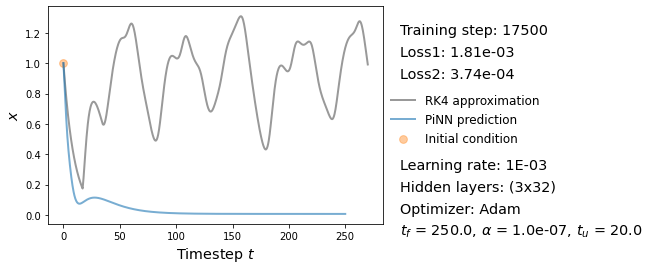

PiNN, iteration: 20000, loss1: 0.0001475599710829556, loss2: 0.00037221479578875005, time: 1:36:25.280054


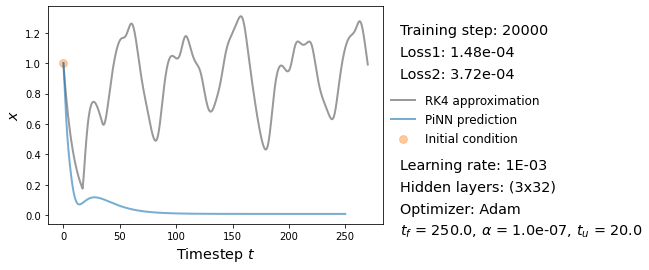

PiNN, iteration: 22500, loss1: 2.149960209862911e-06, loss2: 0.00036933415685780346, time: 1:36:34.333548


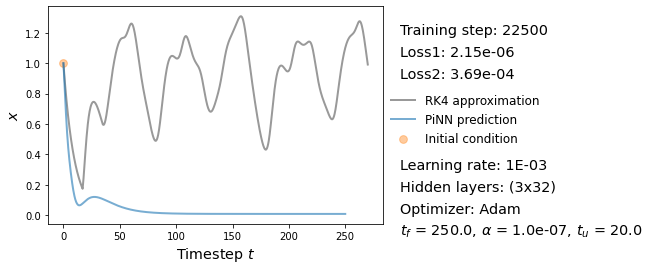

PiNN, iteration: 25000, loss1: 0.0005329116247594357, loss2: 0.00036222077324055135, time: 1:36:43.016204


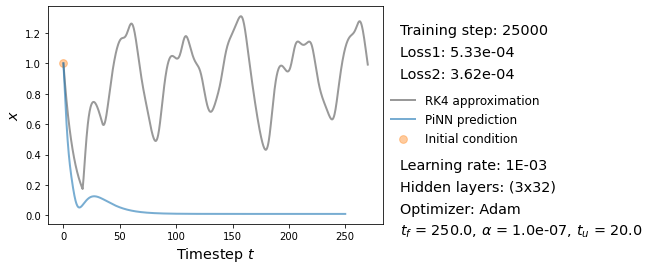

PiNN, iteration: 27500, loss1: 0.0024245181120932102, loss2: 0.00026202804292552173, time: 1:36:51.695828


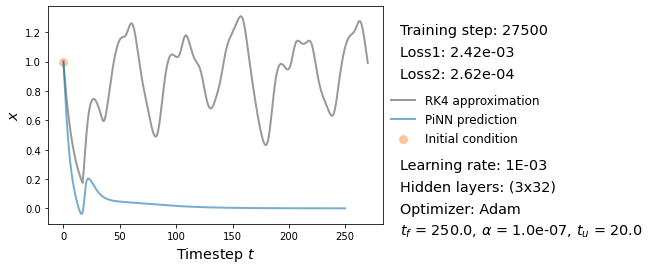

PiNN, iteration: 30000, loss1: 1.3928058706369484e-06, loss2: 0.0002463556593284011, time: 1:37:00.598811


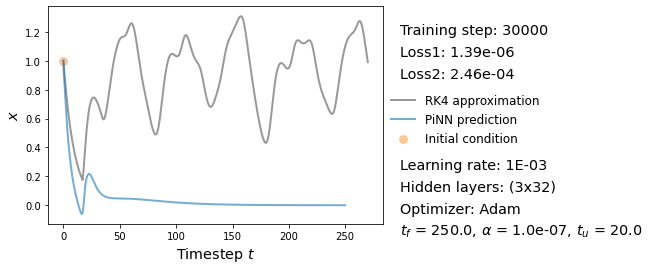

PiNN, iteration: 32500, loss1: 0.012685277499258518, loss2: 2.012803452089429e-05, time: 1:37:09.954229


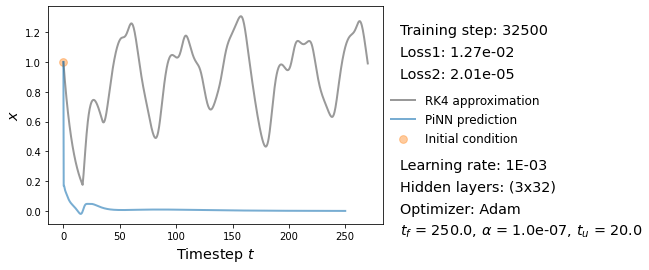

PiNN, iteration: 35000, loss1: 8.645884008728899e-07, loss2: 9.210978532792069e-06, time: 1:37:19.196822


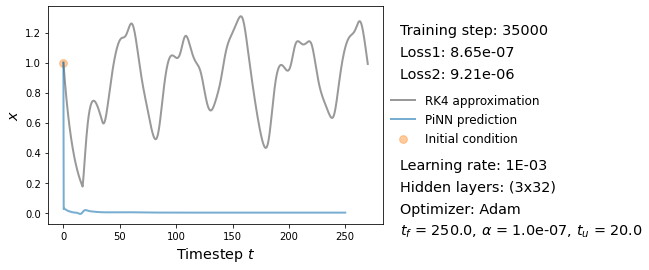

PiNN, iteration: 37500, loss1: 7.258336154336575e-06, loss2: 8.825874829199165e-06, time: 1:37:29.945058


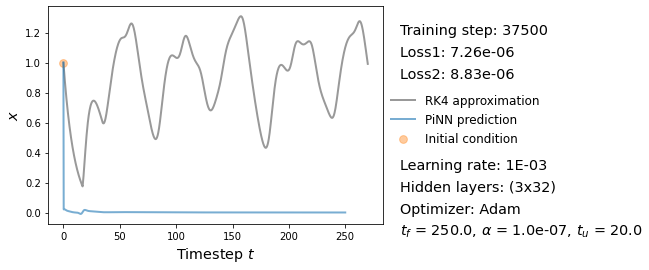

PiNN, iteration: 40000, loss1: 1.80608949449379e-05, loss2: 8.510376574122347e-06, time: 1:37:39.271453


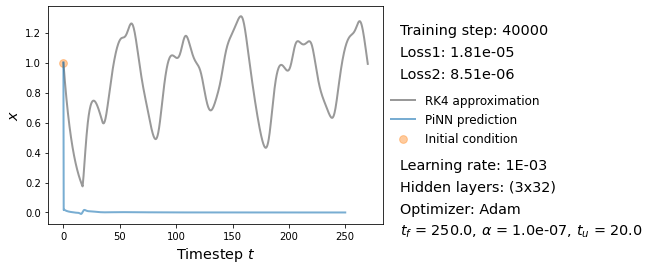

PiNN, iteration: 42500, loss1: 0.00010485919483471662, loss2: 8.299984983750619e-06, time: 1:37:48.392050


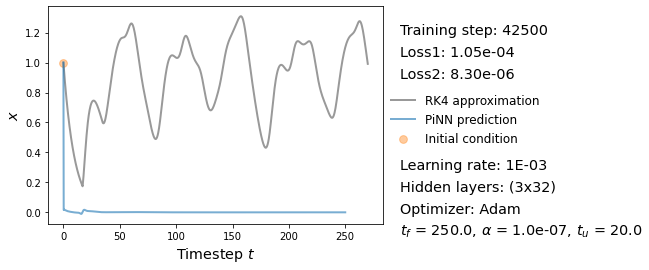

PiNN, iteration: 45000, loss1: 0.012180203571915627, loss2: 8.404814252571668e-06, time: 1:37:57.536064


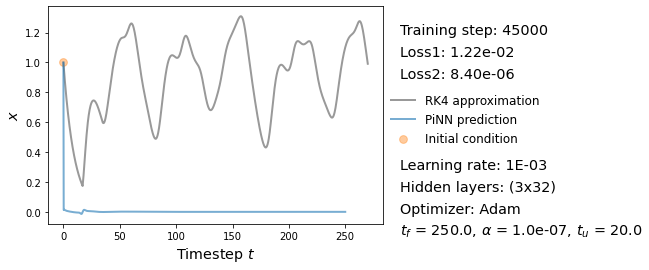

PiNN, iteration: 47500, loss1: 0.0003171913849655539, loss2: 7.835845281078946e-06, time: 1:38:06.752630


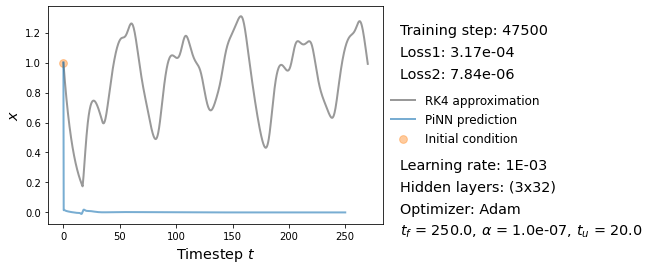

PiNN, iteration: 50000, loss1: 9.754899110703263e-06, loss2: 7.509900569857564e-06, time: 1:38:15.984770


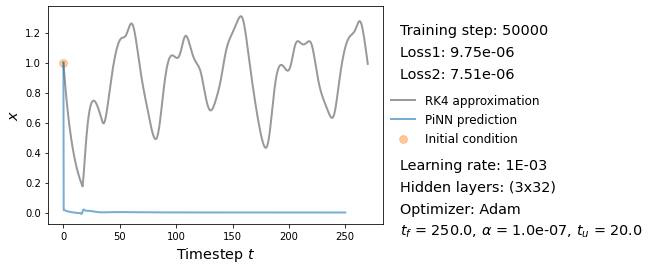

PiNN, iteration: 52500, loss1: 0.0061846221797168255, loss2: 7.227337846416049e-06, time: 1:38:25.113464


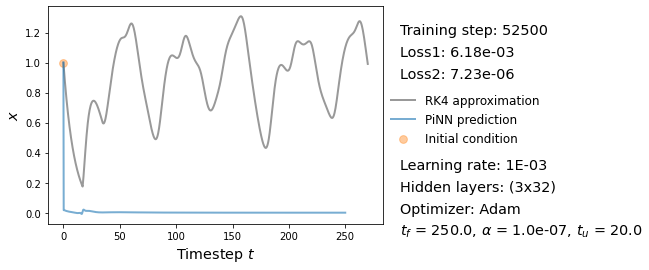

PiNN, iteration: 55000, loss1: 9.369841427542269e-05, loss2: 6.694786407024367e-06, time: 1:38:34.281826


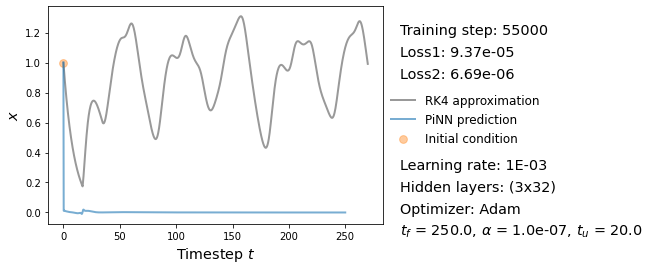

PiNN, iteration: 57500, loss1: 5.640288236463675e-07, loss2: 6.272681730479235e-06, time: 1:38:43.434642


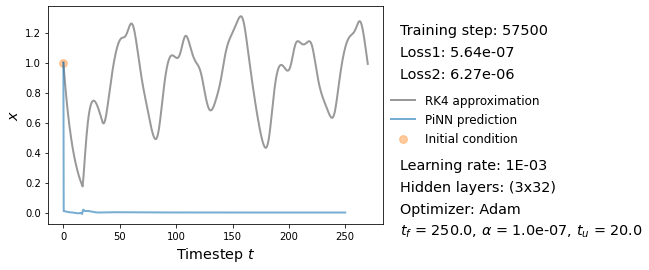

PiNN, iteration: 60000, loss1: 0.0012241549557074904, loss2: 6.10512142884545e-06, time: 1:38:52.635575


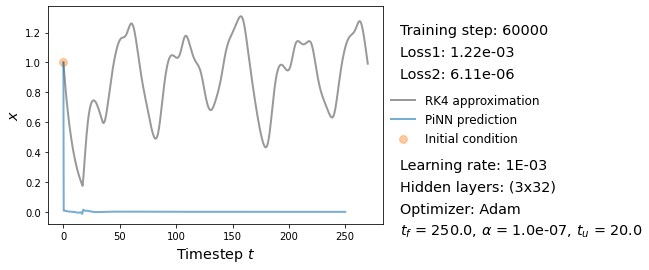

PiNN, iteration: 62500, loss1: 4.352074029156938e-06, loss2: 5.287577550916467e-06, time: 1:39:01.974169


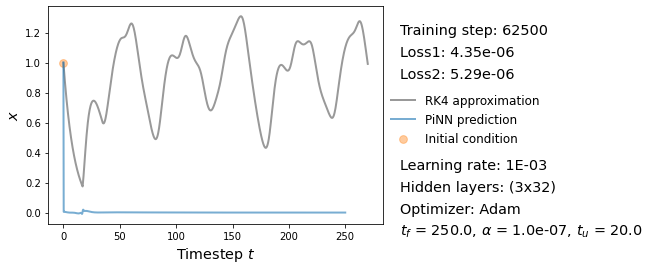

PiNN, iteration: 65000, loss1: 2.310152012796607e-06, loss2: 4.719003300124314e-06, time: 1:39:11.462629


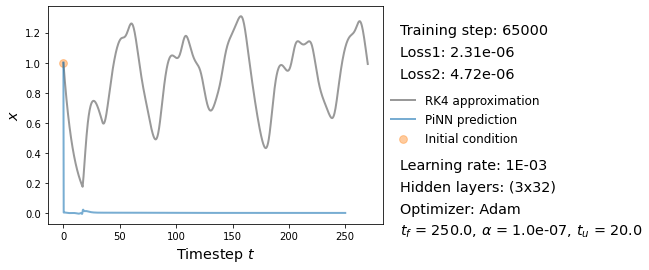

PiNN, iteration: 67500, loss1: 2.8394566470524296e-05, loss2: 5.3582843975164e-06, time: 1:39:20.647127


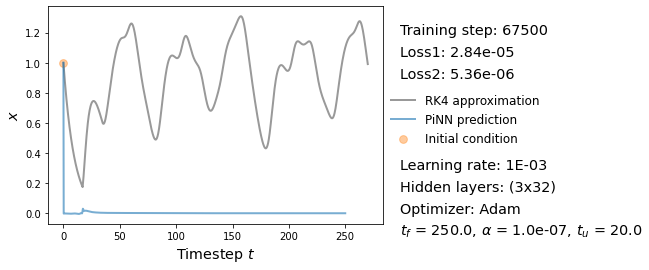

PiNN, iteration: 70000, loss1: 0.003254429204389453, loss2: 2.745059418884921e-06, time: 1:39:29.810450


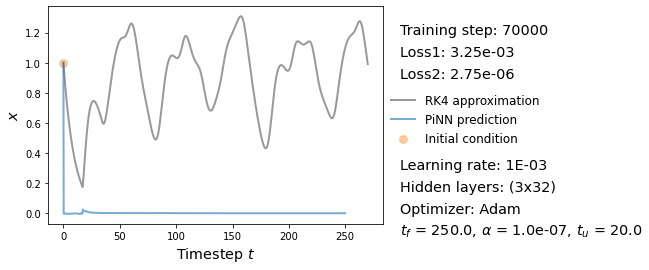

PiNN, iteration: 72500, loss1: 2.5517010726616718e-06, loss2: 1.2644507023651386e-06, time: 1:39:39.013251


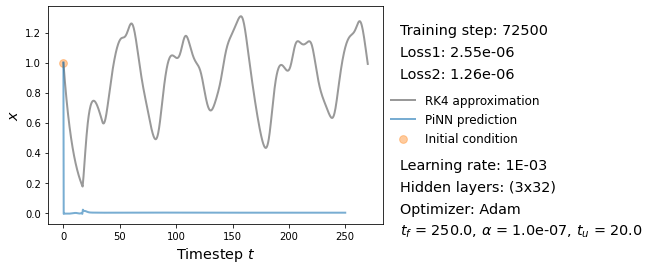

PiNN, iteration: 75000, loss1: 2.2737367544323206e-09, loss2: 6.65131608457159e-07, time: 1:39:48.514394


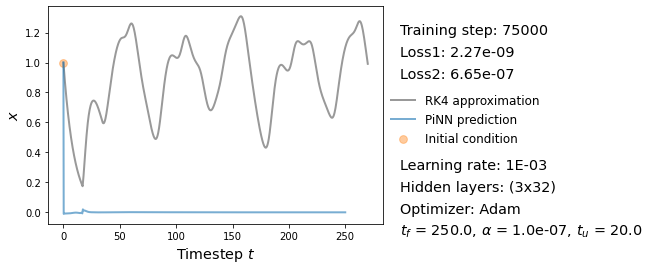

PiNN, iteration: 77500, loss1: 5.487130692927167e-06, loss2: 9.13172698346898e-06, time: 1:39:57.982921


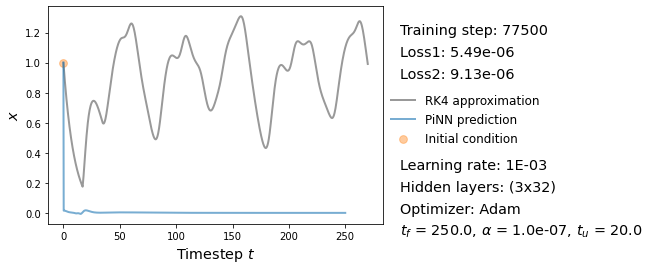

PiNN, iteration: 80000, loss1: 0.0003298413648735732, loss2: 8.344322282027861e-07, time: 1:40:07.082827


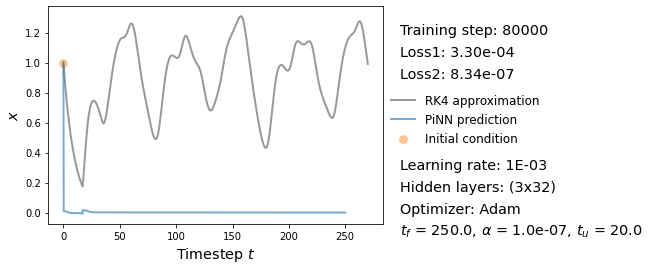

PiNN, iteration: 82500, loss1: 0.002029429655522108, loss2: 9.762072295416147e-06, time: 1:40:16.460439


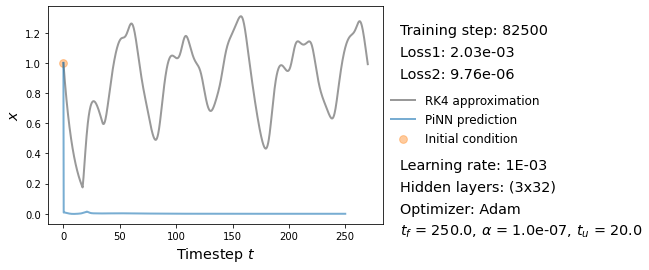

PiNN, iteration: 85000, loss1: 0.0008537030080333352, loss2: 8.605933544458821e-06, time: 1:40:25.755913


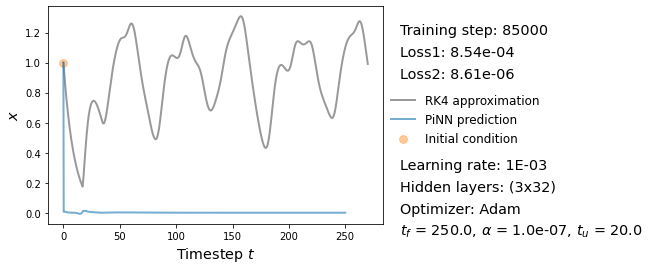

PiNN, iteration: 87500, loss1: 1.3656631381309126e-07, loss2: 8.46556304168189e-06, time: 1:40:35.083701


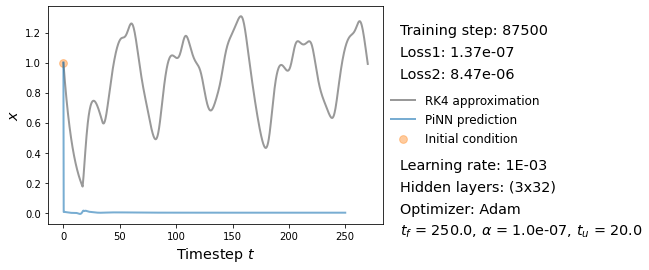

PiNN, iteration: 90000, loss1: 9.606537787476555e-08, loss2: 8.279111170850229e-06, time: 1:40:44.608913


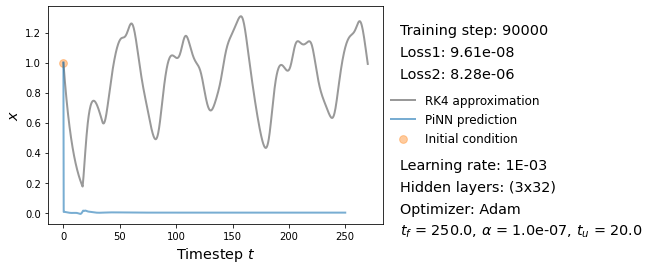

PiNN, iteration: 92500, loss1: 1.0982716958096717e-05, loss2: 7.993789949978236e-06, time: 1:40:54.019082


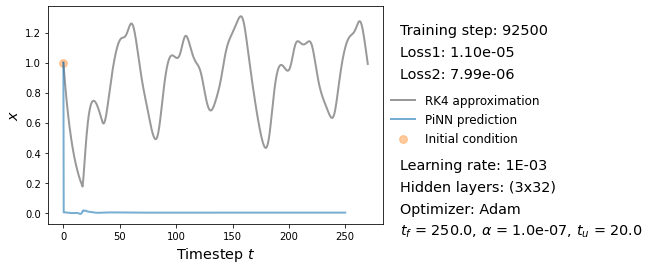

PiNN, iteration: 95000, loss1: 2.929084439529106e-05, loss2: 7.6275018727756105e-06, time: 1:41:03.688586


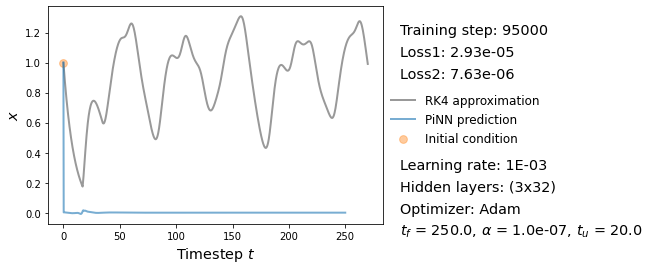

PiNN, iteration: 97500, loss1: 2.9467628337442875e-06, loss2: 7.540268143202411e-06, time: 1:41:13.152562


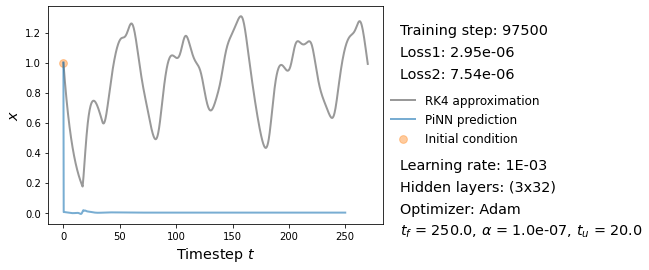

PiNN, iteration: 100000, loss1: 0.0007911524153314531, loss2: 7.220416136988206e-06, time: 1:41:22.728329


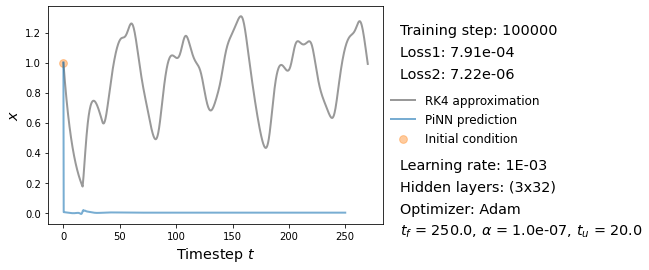

PiNN, iteration: 102500, loss1: 2.1614710021822248e-07, loss2: 8.979751328297425e-06, time: 1:41:31.960949


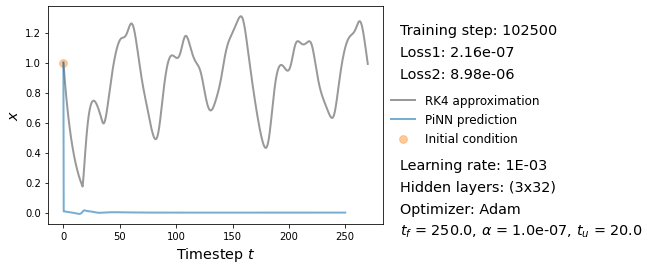

PiNN, iteration: 105000, loss1: 0.0030161754693835974, loss2: 8.549783160560764e-06, time: 1:41:40.865043


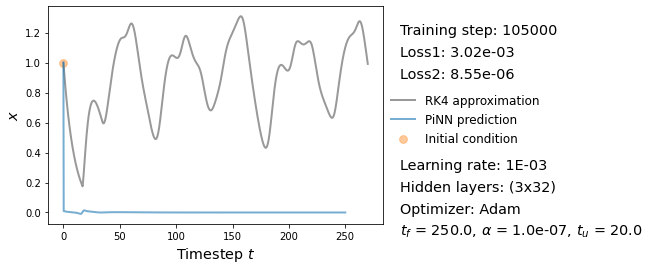

PiNN, iteration: 107500, loss1: 4.2675765143940225e-05, loss2: 7.9591445683036e-06, time: 1:41:50.157056


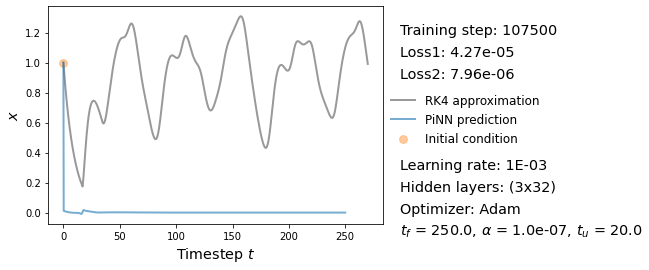

PiNN, iteration: 110000, loss1: 4.106937012693379e-08, loss2: 7.487565653718775e-06, time: 1:41:59.390379


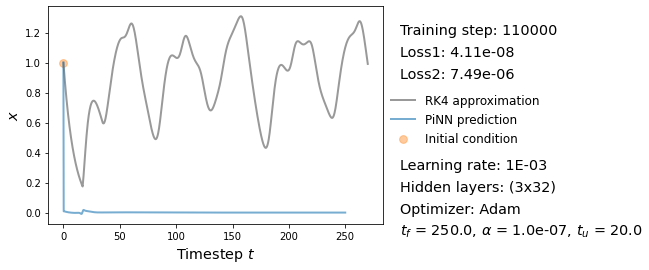

PiNN, iteration: 112500, loss1: 5.1842616812791675e-06, loss2: 6.655761353613343e-06, time: 1:42:08.621044


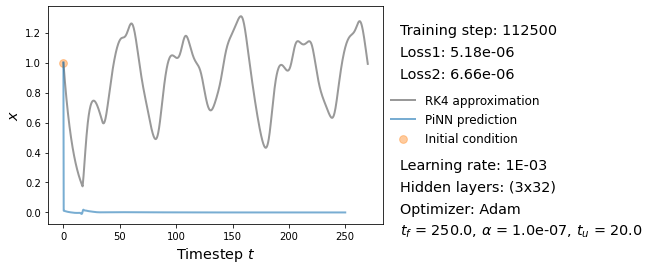

PiNN, iteration: 115000, loss1: 0.0009628719417378306, loss2: 4.96322081744438e-06, time: 1:42:17.528473


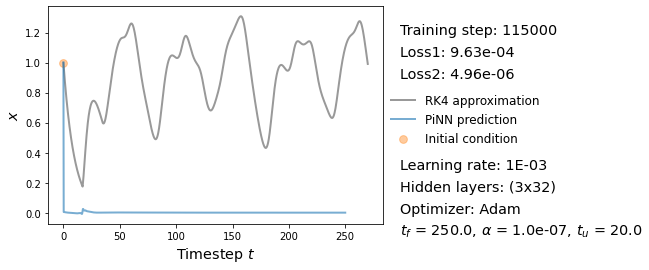

PiNN, iteration: 117500, loss1: 5.1301185521879233e-08, loss2: 2.646958819241263e-06, time: 1:42:26.454046


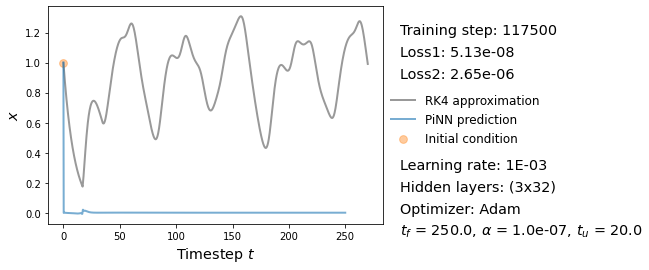

PiNN, iteration: 120000, loss1: 1.4210854715202004e-08, loss2: 6.023969945090357e-07, time: 1:42:35.744446


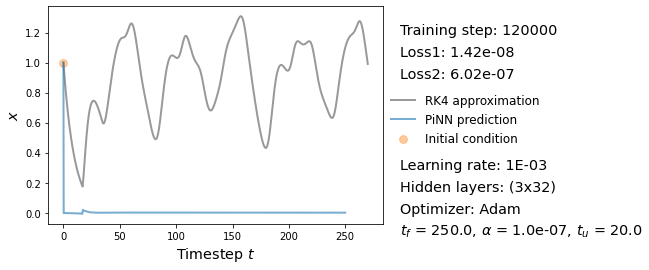

PiNN, iteration: 122500, loss1: 2.0520474208751693e-07, loss2: 2.33828785667356e-07, time: 1:42:44.905042


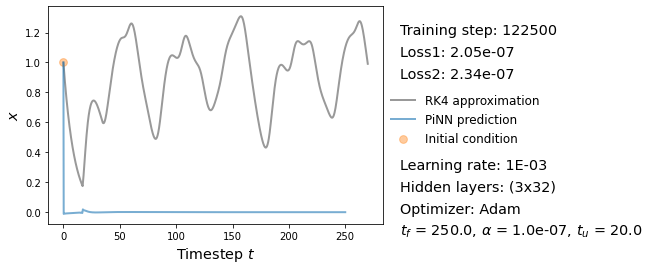

PiNN, iteration: 125000, loss1: 8.185452315956354e-08, loss2: 9.956341273209546e-06, time: 1:42:54.170837


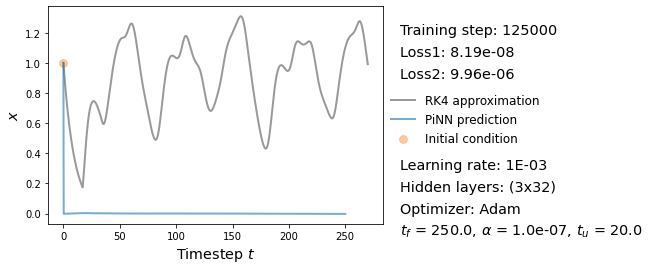

PiNN, iteration: 127500, loss1: 3.9019596442813054e-05, loss2: 9.911972483678255e-06, time: 1:43:03.268922


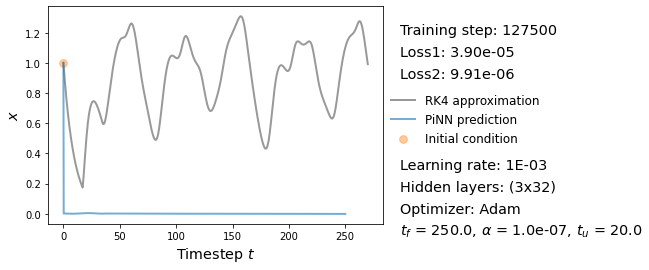

PiNN, iteration: 130000, loss1: 5.167194831301458e-05, loss2: 1.000332849798724e-05, time: 1:43:12.514207


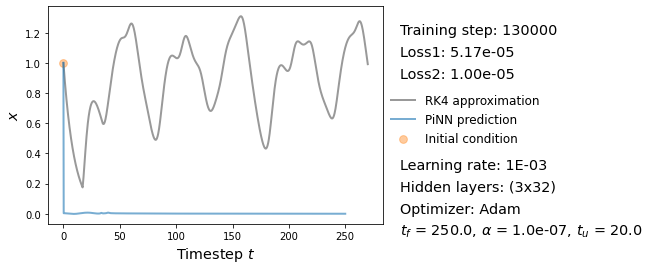

PiNN, iteration: 132500, loss1: 1.8417267710901797e-07, loss2: 9.742305337567814e-06, time: 1:43:21.822937


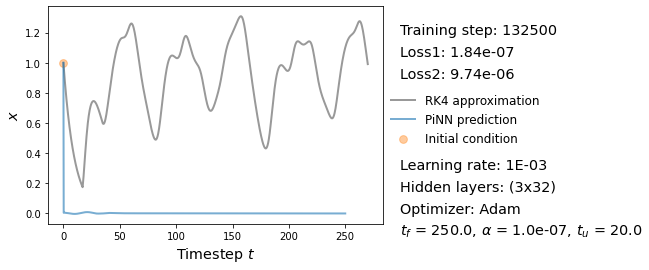

PiNN, iteration: 135000, loss1: 1.5195524611044675e-05, loss2: 9.60026682150783e-06, time: 1:43:30.869261


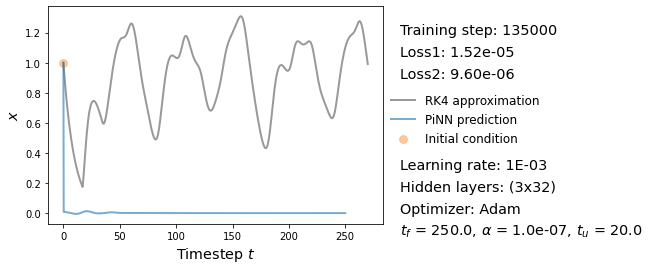

PiNN, iteration: 137500, loss1: 1.6427748050773516e-07, loss2: 9.163696631731e-06, time: 1:43:39.904101


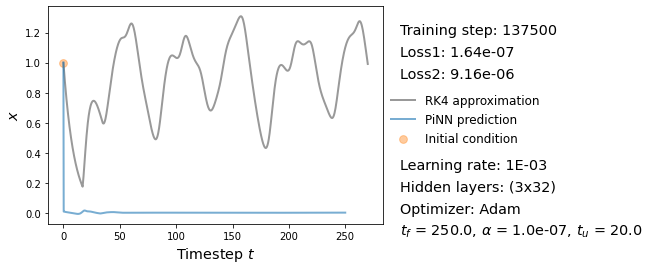

PiNN, iteration: 140000, loss1: 2.0463630789890885e-08, loss2: 5.654593223880511e-06, time: 1:43:48.983140


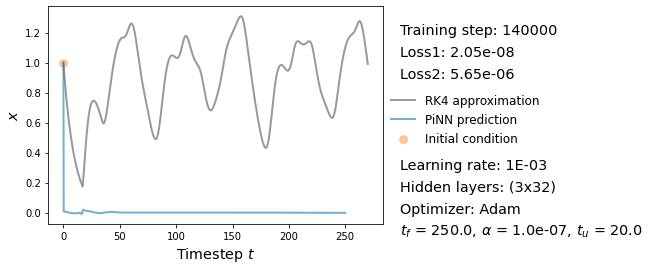

PiNN, iteration: 142500, loss1: 9.555378710501827e-07, loss2: 4.814700673705374e-07, time: 1:43:58.139181


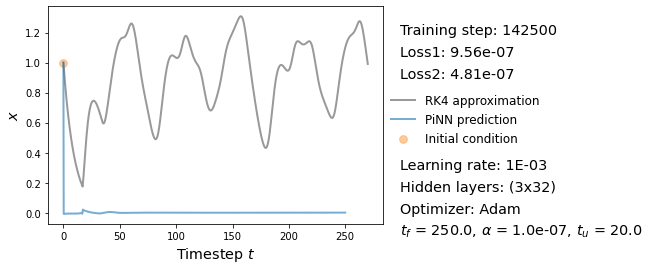

PiNN, iteration: 145000, loss1: 1.4210854715202004e-10, loss2: 2.7794558832283656e-07, time: 1:44:07.278277


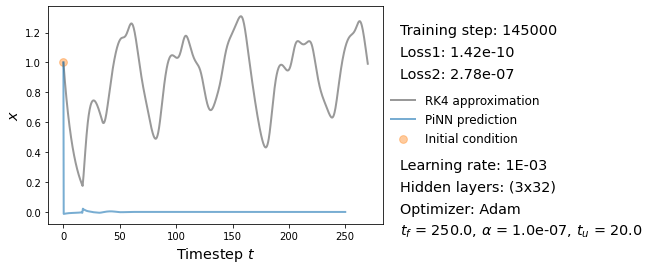

PiNN, iteration: 147500, loss1: 1.7408296116627753e-05, loss2: 4.3419052531135094e-07, time: 1:44:16.378997


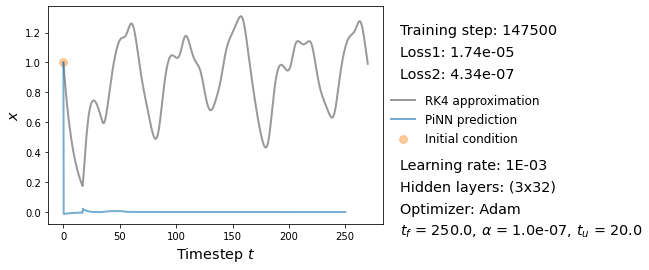

PiNN, iteration: 150000, loss1: 2.5910509066306986e-05, loss2: 1.9256765426689526e-07, time: 1:44:25.465564


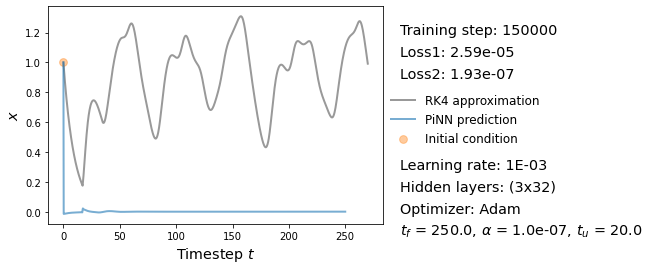

PiNN, iteration: 152500, loss1: 1.4210854715202004e-10, loss2: 8.36823943473064e-08, time: 1:44:34.475722


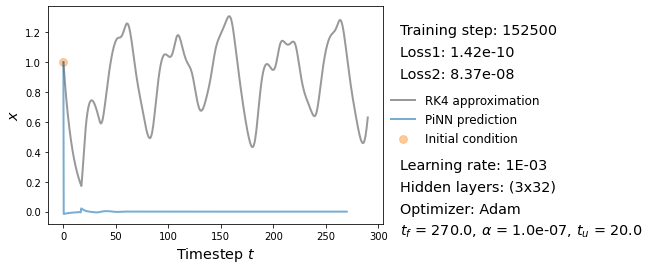

PiNN, iteration: 155000, loss1: 1.3370993201533565e-06, loss2: 6.273609898244104e-08, time: 1:44:43.681656


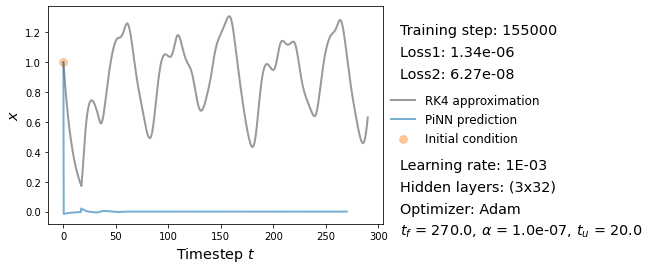

PiNN, iteration: 157500, loss1: 1.6427748050773516e-07, loss2: 9.99203712126473e-06, time: 1:44:52.606461


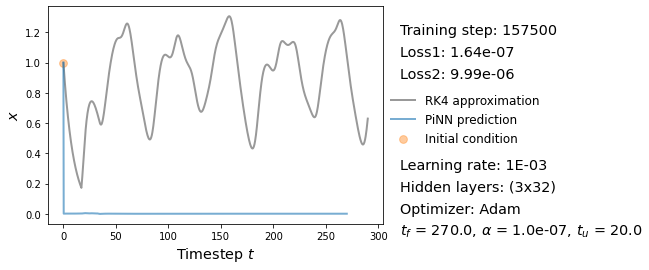

PiNN, iteration: 160000, loss1: 8.185452315956354e-08, loss2: 9.802310160011984e-06, time: 1:45:01.870541


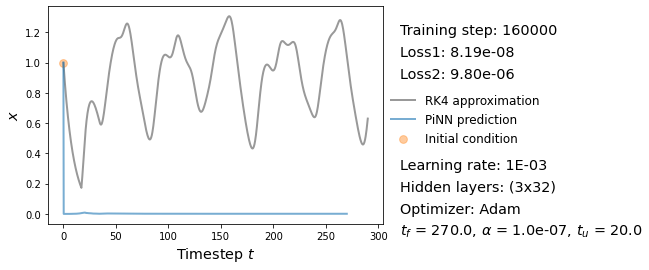

PiNN, iteration: 162500, loss1: 1.2028067430946976e-06, loss2: 7.947646736283787e-06, time: 1:45:11.314006


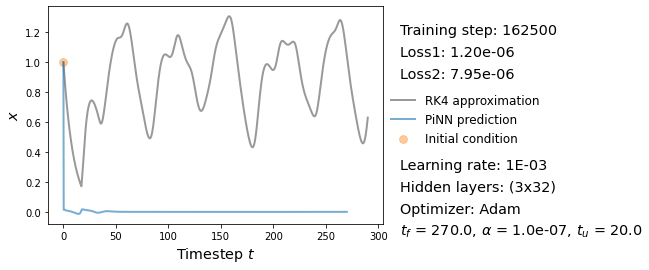

PiNN, iteration: 165000, loss1: 0.0012166589731350541, loss2: 5.605287469734321e-07, time: 1:45:20.558173


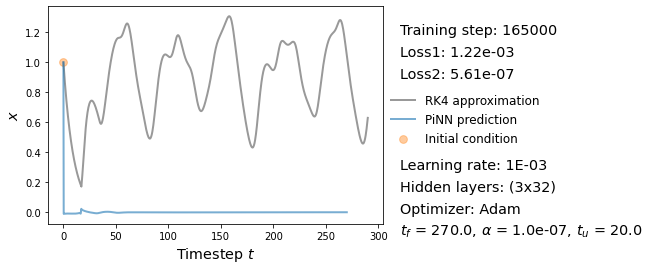

PiNN, iteration: 167500, loss1: 9.094947017729282e-09, loss2: 3.0047456789361604e-07, time: 1:45:29.935665


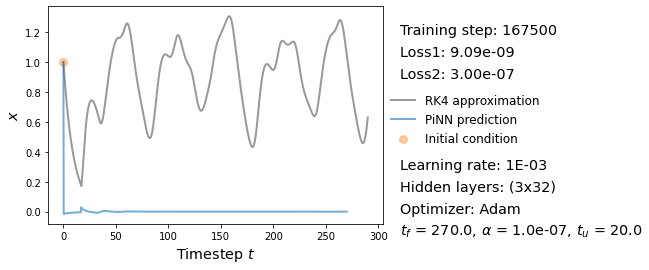

PiNN, iteration: 170000, loss1: 0.00035162331187166274, loss2: 1.2700746765403892e-07, time: 1:45:39.304846


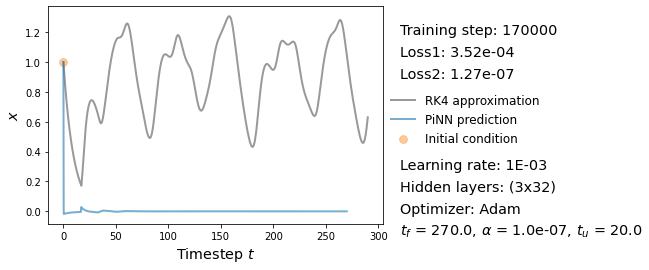

PiNN, iteration: 172500, loss1: 9.606537787476555e-08, loss2: 8.914572390494868e-06, time: 1:45:48.770256


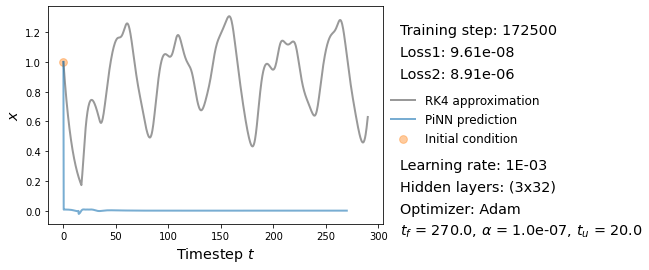

PiNN, iteration: 175000, loss1: 0.00010437148011988029, loss2: 6.11679161011125e-06, time: 1:45:58.053990


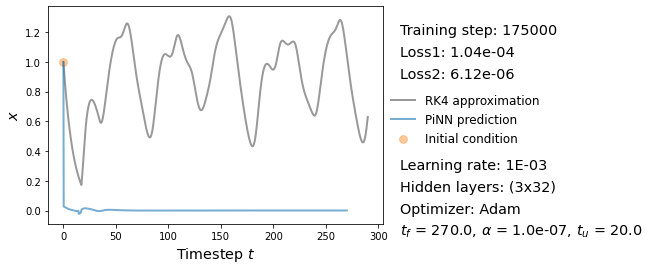

PiNN, iteration: 177500, loss1: 7.572964477731148e-07, loss2: 9.13431813387433e-06, time: 1:46:07.143860


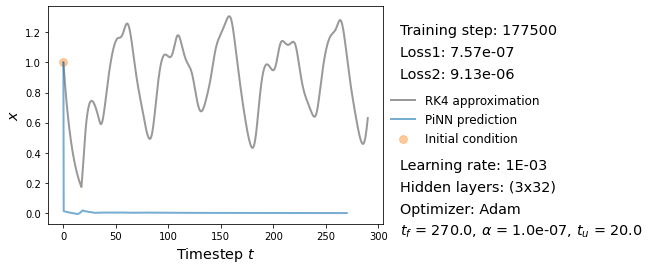

PiNN, iteration: 180000, loss1: 0.0017438152572140098, loss2: 7.5970456236973405e-06, time: 1:46:16.571936


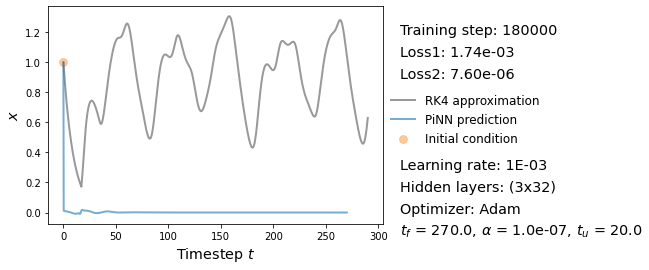

PiNN, iteration: 182500, loss1: 1.5663772501284257e-05, loss2: 4.127964075451018e-06, time: 1:46:26.117559


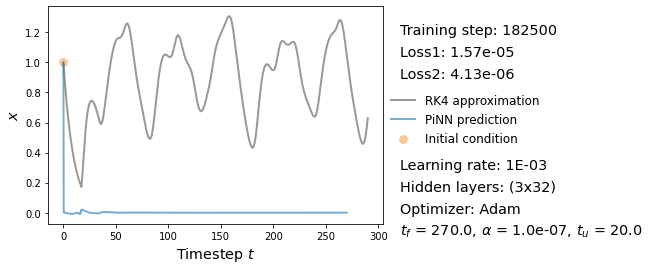

PiNN, iteration: 185000, loss1: 3.206324254279025e-05, loss2: 2.1516564174817177e-07, time: 1:46:35.513985


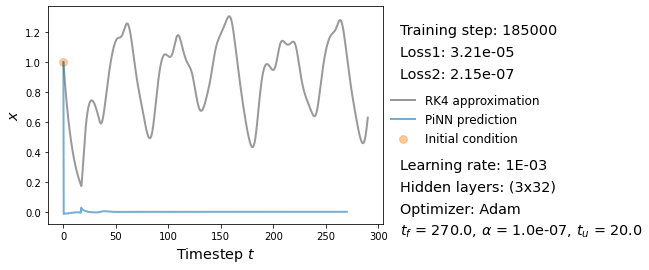

PiNN, iteration: 187500, loss1: 1.2789769243681803e-09, loss2: 8.473155332922033e-08, time: 1:46:44.617635


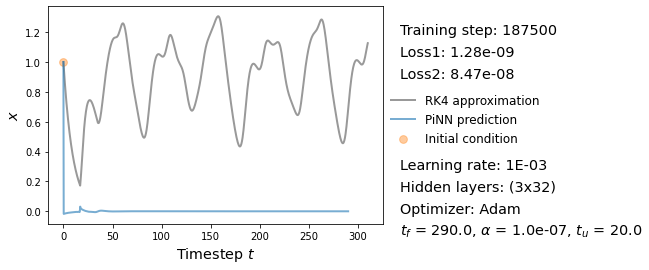

PiNN, iteration: 190000, loss1: 5.436252467916347e-05, loss2: 9.299934333739657e-08, time: 1:46:53.863632


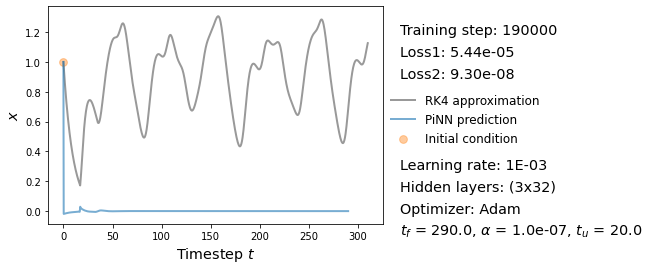

PiNN, iteration: 192500, loss1: 0.0008662881446070969, loss2: 1.1524818432917527e-07, time: 1:47:03.071071


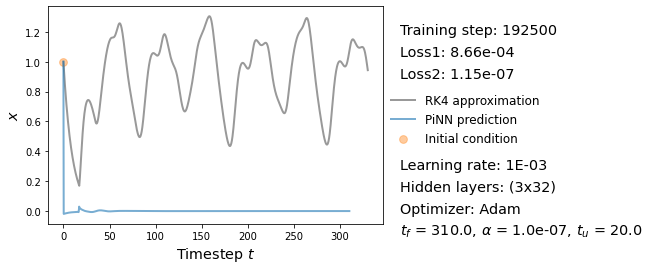

PiNN, iteration: 195000, loss1: 5.1301185521879233e-08, loss2: 7.984319694287478e-08, time: 1:47:12.292783


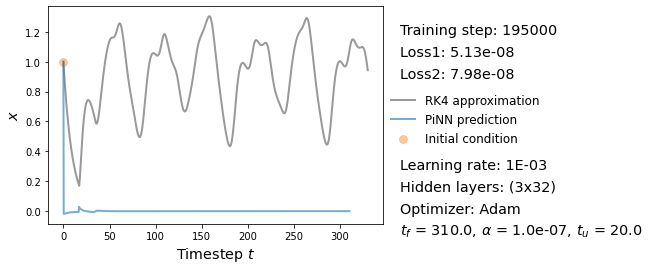

PiNN, iteration: 197500, loss1: 2.3648283331567654e-06, loss2: 6.468921753821633e-08, time: 1:47:21.496140


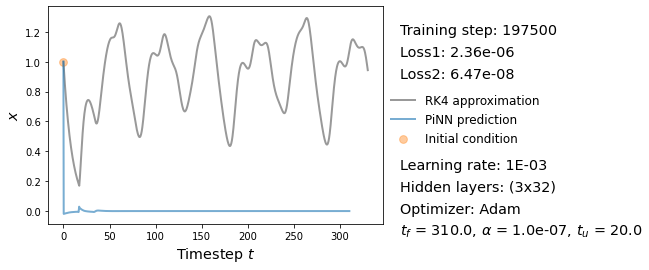

PiNN, iteration: 200000, loss1: 4.5278979996510316e-06, loss2: 6.438033750555405e-08, time: 1:47:30.488005


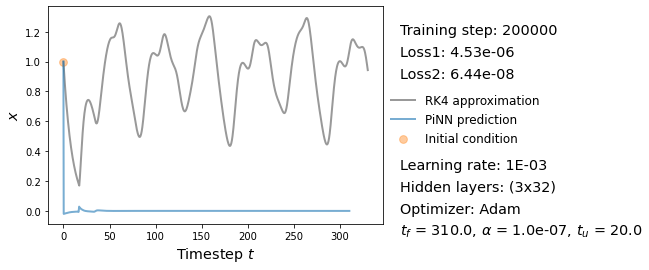

PiNN, iteration: 202500, loss1: 5.684341886080801e-10, loss2: 5.601960495482672e-08, time: 1:47:39.501297


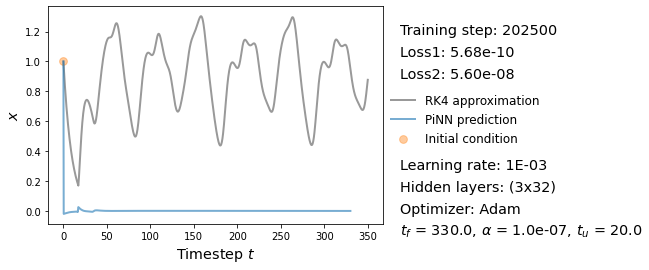

PiNN, iteration: 205000, loss1: 9.459313332627062e-06, loss2: 1.4489577324638958e-06, time: 1:47:48.449697


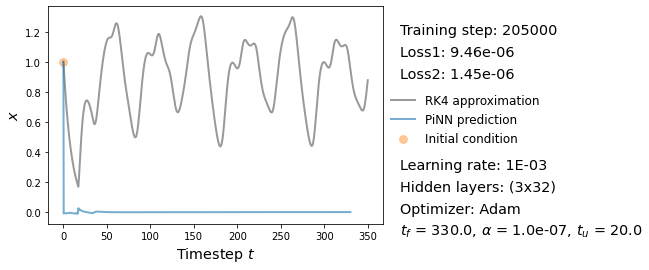

PiNN, iteration: 207500, loss1: 0.002601984655484557, loss2: 2.3639972823730204e-07, time: 1:47:57.462573


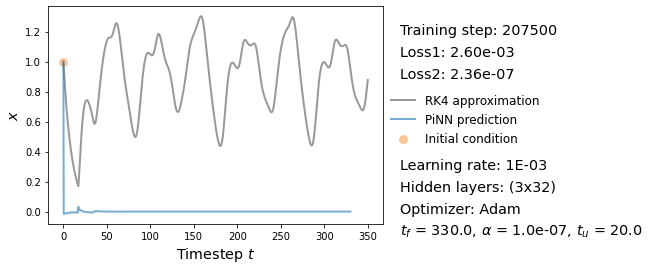

PiNN, iteration: 210000, loss1: 1.2825296380469808e-08, loss2: 8.784007121676041e-08, time: 1:48:06.604468


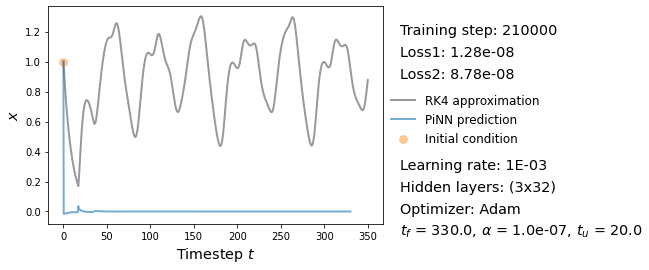

PiNN, iteration: 212500, loss1: 0.0010452003916725516, loss2: 8.457600131350773e-08, time: 1:48:15.632623


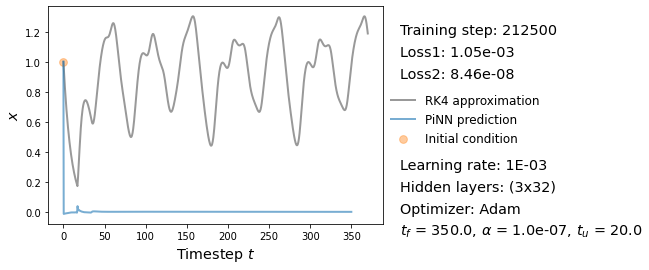

PiNN, iteration: 215000, loss1: 1.4551915228366852e-07, loss2: 1.0073390512843616e-05, time: 1:48:24.801924


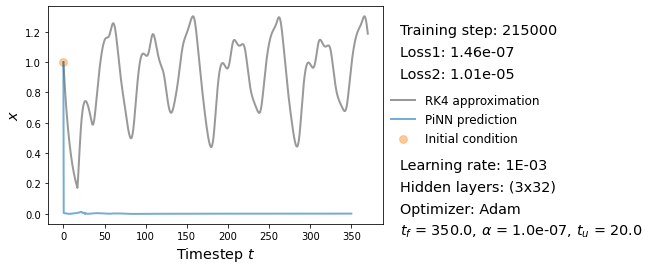

PiNN, iteration: 217500, loss1: 7.572964477731148e-07, loss2: 9.325229257228784e-06, time: 1:48:33.765229


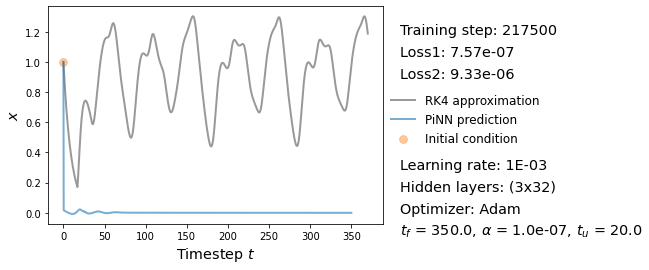

PiNN, iteration: 220000, loss1: 6.571099220309407e-07, loss2: 8.199586773116607e-06, time: 1:48:42.765218


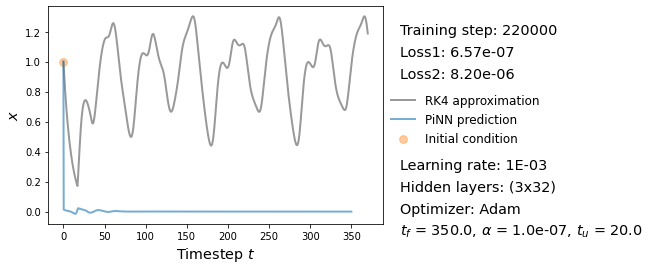

PiNN, iteration: 222500, loss1: 2.2737367544323206e-09, loss2: 3.846747858915478e-06, time: 1:48:51.846979


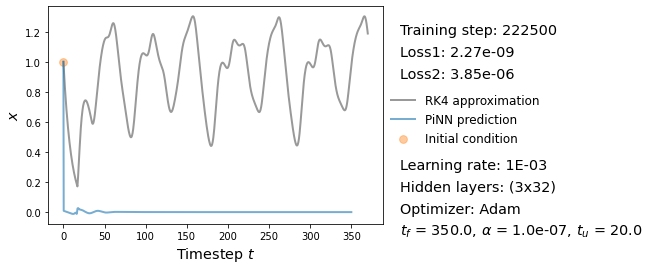

PiNN, iteration: 225000, loss1: 0.01527012512087822, loss2: 1.0272457302562543e-06, time: 1:49:01.153656


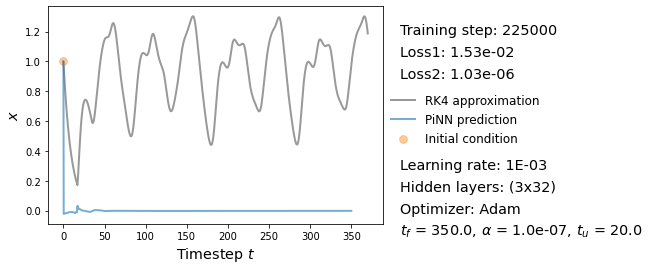

PiNN, iteration: 227500, loss1: 0.00011155464017065242, loss2: 1.5738022796085716e-07, time: 1:49:10.721194


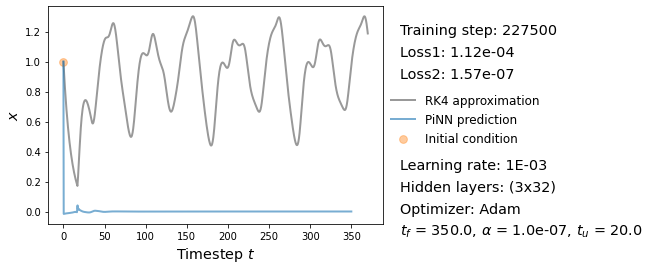

PiNN, iteration: 230000, loss1: 3.552713678800501e-11, loss2: 1.3823209599195252e-07, time: 1:49:20.186120


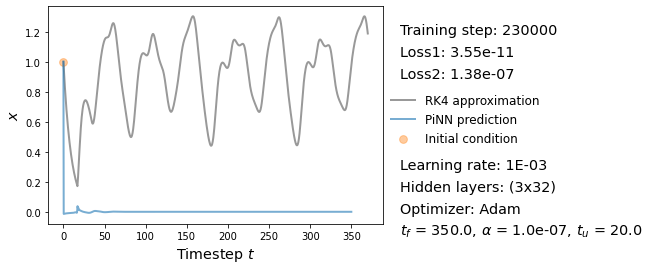

PiNN, iteration: 232500, loss1: 0.001977672101929784, loss2: 9.192804384383635e-08, time: 1:49:29.426345


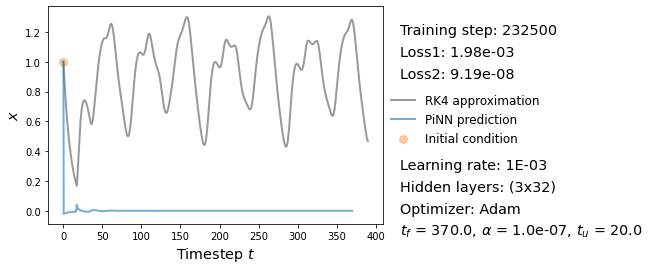

PiNN, iteration: 235000, loss1: 3.240216983613209e-06, loss2: 8.368334647457232e-08, time: 1:49:38.910417


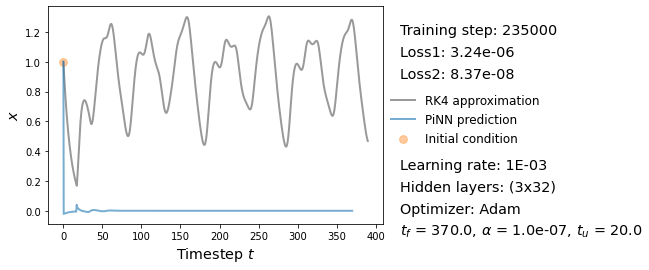

PiNN, iteration: 237500, loss1: 1.2789769243681803e-09, loss2: 6.55591705367442e-08, time: 1:49:48.370191


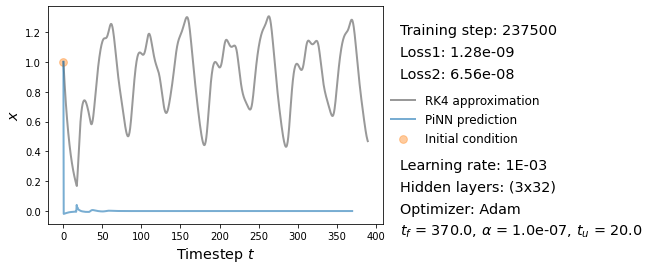

PiNN, iteration: 240000, loss1: 6.963318810448982e-09, loss2: 5.796788826728516e-08, time: 1:49:57.738356


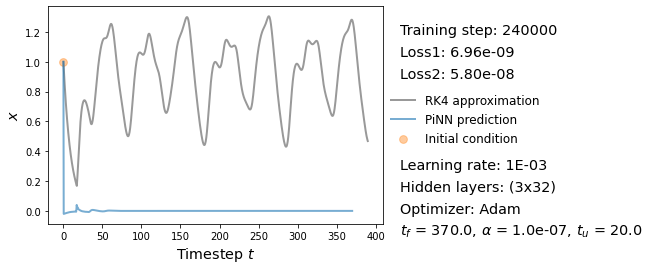

PiNN, iteration: 242500, loss1: 2.639822560013272e-05, loss2: 4.0943184842490155e-08, time: 1:50:07.092111


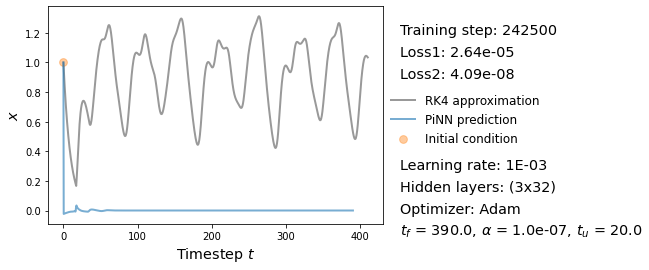

PiNN, iteration: 245000, loss1: 2.388844677625457e-07, loss2: 3.4356222755604904e-08, time: 1:50:16.274165


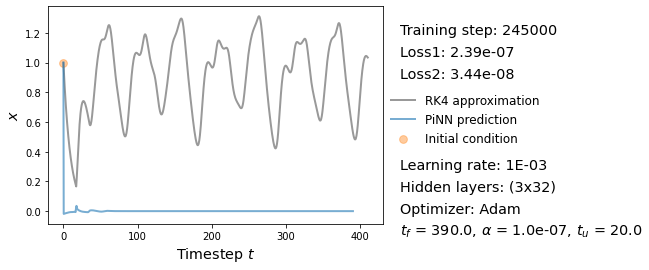

PiNN, iteration: 247500, loss1: 0.00022453846759162843, loss2: 3.0072314416429435e-08, time: 1:50:25.588158


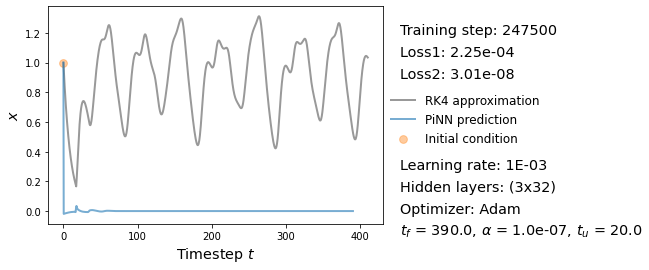

PiNN, iteration: 250000, loss1: 8.100542618194595e-05, loss2: 5.233323818742974e-08, time: 1:50:34.982484


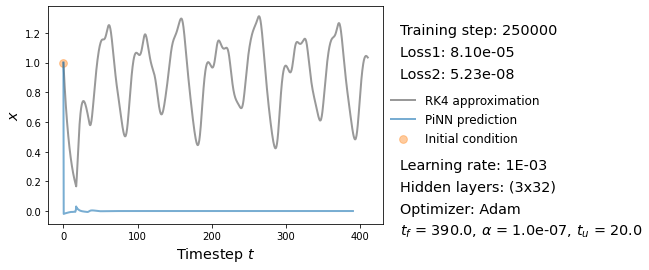

PiNN, iteration: 252500, loss1: 0.003958757966756821, loss2: 3.995382868993147e-08, time: 1:50:44.205525


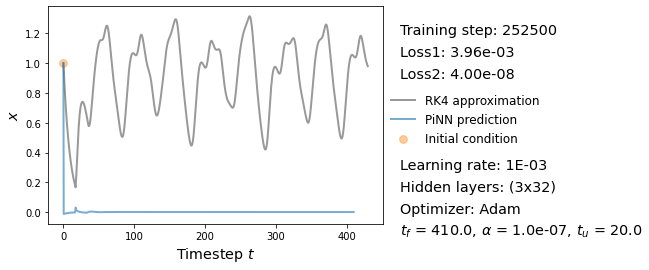

PiNN, iteration: 255000, loss1: 5.684341886080801e-10, loss2: 3.44523662931806e-08, time: 1:50:53.418998


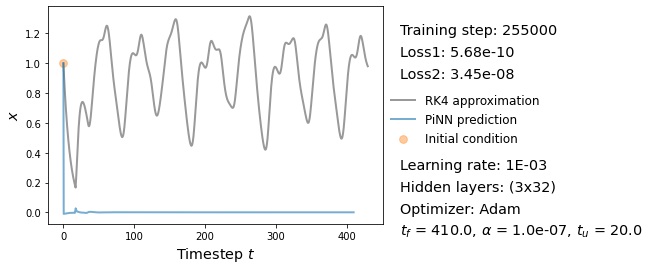

PiNN, iteration: 257500, loss1: 5.640288236463675e-07, loss2: 2.842857327323145e-08, time: 1:51:02.668193


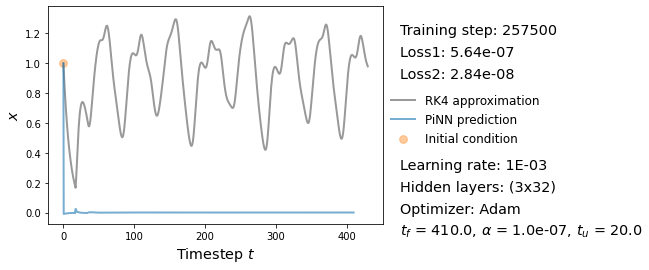

PiNN, iteration: 260000, loss1: 0.000154148307046853, loss2: 2.2377827590958077e-08, time: 1:51:12.018671


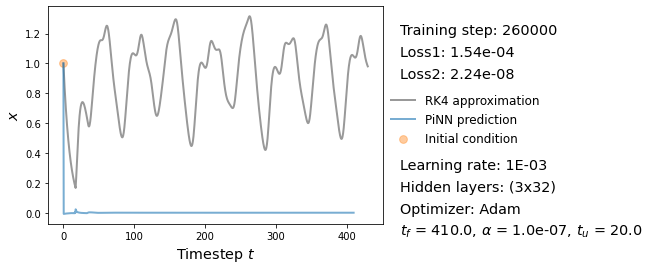

PiNN, iteration: 262500, loss1: 3.552713678800501e-09, loss2: 1.948254357841961e-08, time: 1:51:21.409308


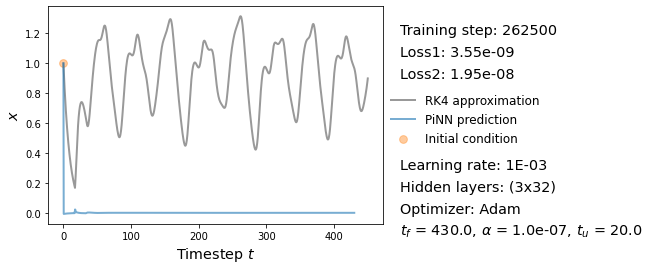

PiNN, iteration: 265000, loss1: 1.2366996088530868e-05, loss2: 1.8160935866262662e-08, time: 1:51:30.840243


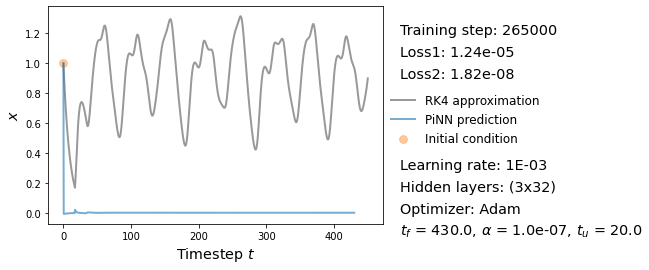

PiNN, iteration: 267500, loss1: 3.9019596442813054e-05, loss2: 6.183908141110805e-08, time: 1:51:40.146836


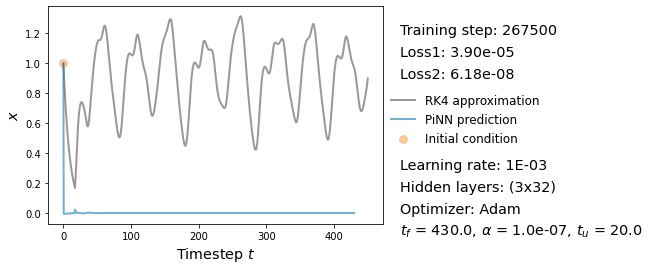

PiNN, iteration: 270000, loss1: 5.684341886080801e-10, loss2: 8.255373984411563e-08, time: 1:51:49.392928


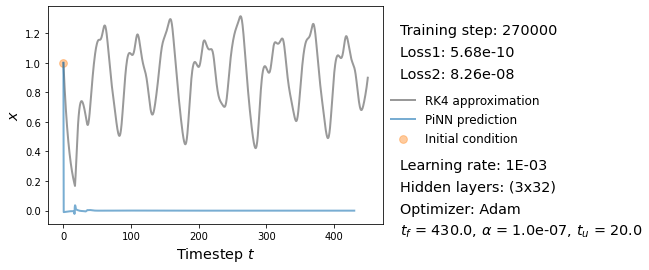

PiNN, iteration: 272500, loss1: 0.006872101686894894, loss2: 2.4456204172906837e-08, time: 1:51:58.610864


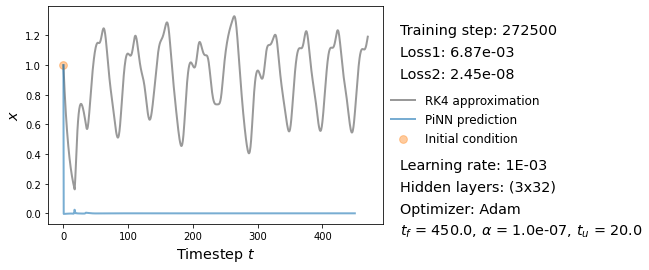

PiNN, iteration: 275000, loss1: 9.78985781330266e-07, loss2: 7.159352666263885e-09, time: 1:52:07.789971


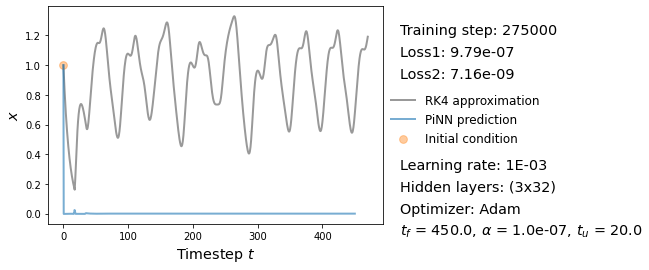

PiNN, iteration: 277500, loss1: 5.684341886080801e-10, loss2: 1.342941668980302e-08, time: 1:52:17.085523


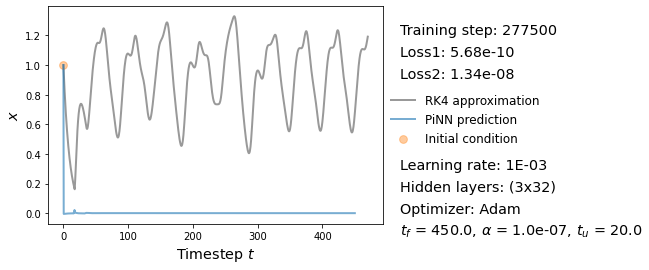

PiNN, iteration: 280000, loss1: 4.106937012693379e-08, loss2: 1.3256364894687067e-08, time: 1:52:26.311248


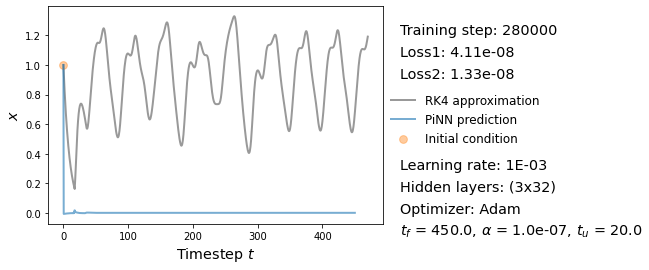

PiNN, iteration: 282500, loss1: 2.7853275241795927e-08, loss2: 9.833185686147772e-06, time: 1:52:35.433833


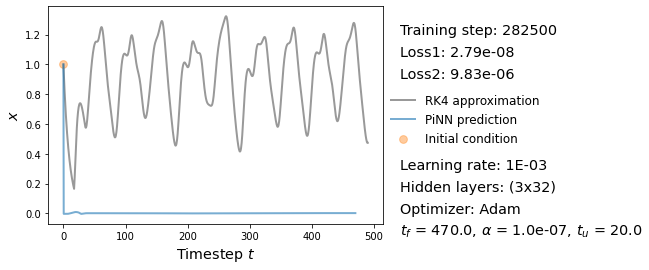

PiNN, iteration: 285000, loss1: 0.0008627830538898706, loss2: 9.72443558566738e-06, time: 1:52:44.477901


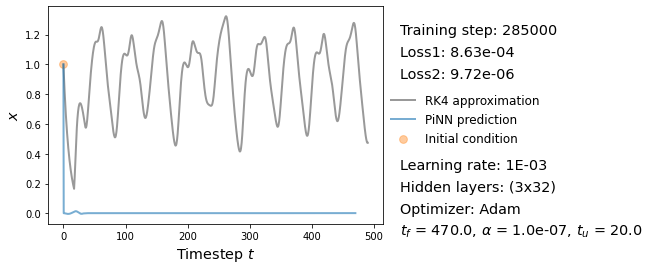

PiNN, iteration: 287500, loss1: 0.0005596575792878866, loss2: 8.73750923346961e-06, time: 1:52:53.452493


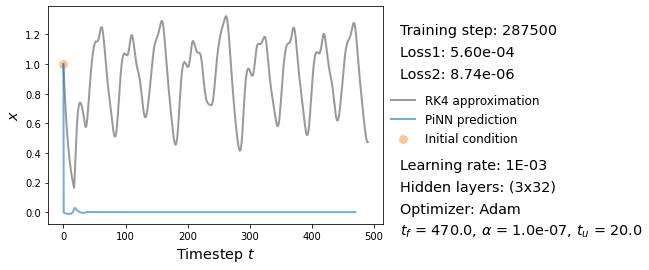

PiNN, iteration: 290000, loss1: 3.637978807091713e-08, loss2: 5.299939402902965e-07, time: 1:53:02.343544


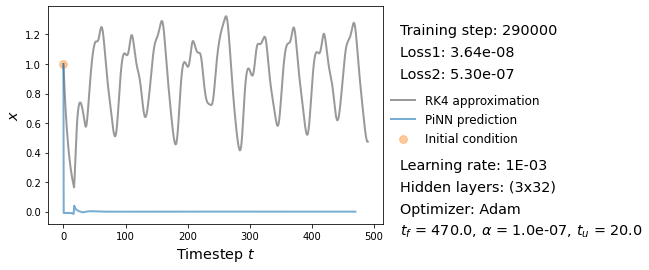

PiNN, iteration: 292500, loss1: 4.6009205107111484e-05, loss2: 4.823087920158287e-07, time: 1:53:11.394674


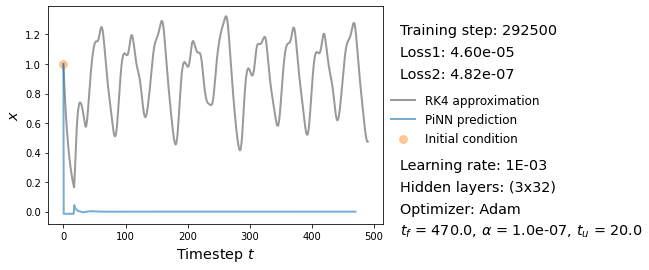

PiNN, iteration: 295000, loss1: 0.0001679110573604703, loss2: 3.439913029978925e-07, time: 1:53:20.238488


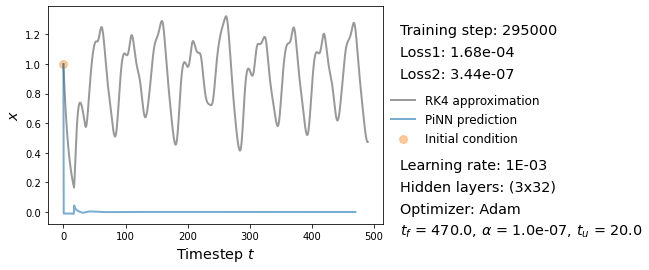

PiNN, iteration: 297500, loss1: 1.2789769243681803e-09, loss2: 3.152000829231838e-07, time: 1:53:29.284417


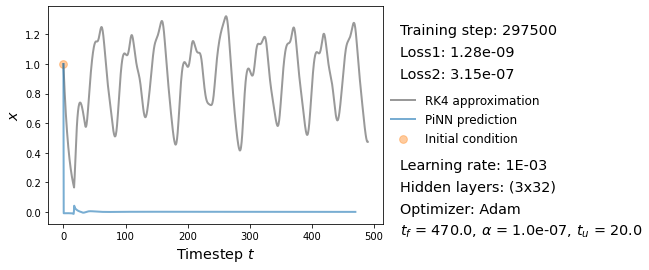

PiNN, iteration: 300000, loss1: 1.8571065083961003e-05, loss2: 3.1494138852394826e-07, time: 1:53:38.429521


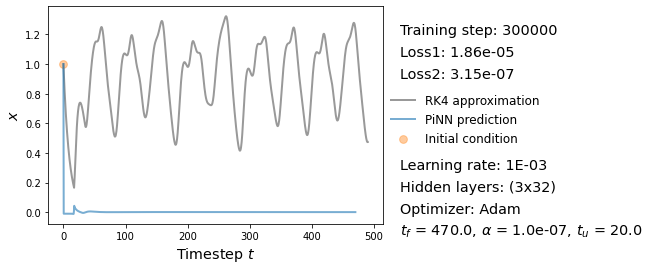

PiNN, iteration: 302500, loss1: 5.684341886080801e-10, loss2: 2.9506824716918345e-07, time: 1:53:47.395815


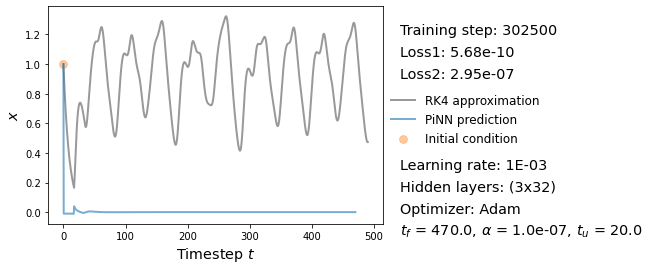

PiNN, iteration: 305000, loss1: 2.220446049250313e-06, loss2: 2.5498394506939803e-07, time: 1:53:56.474189


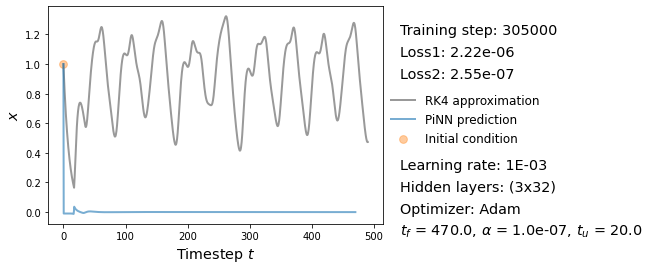

PiNN, iteration: 307500, loss1: 0.0002485487493686378, loss2: 2.873900939448504e-07, time: 1:54:05.452298


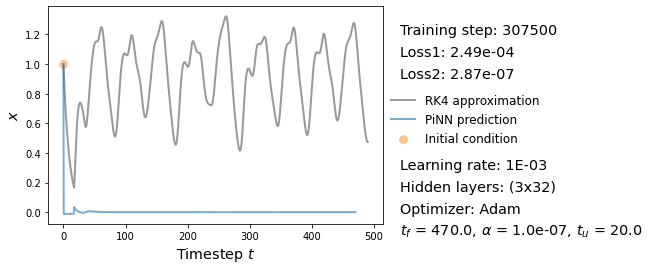

PiNN, iteration: 310000, loss1: 1.051375875249505e-05, loss2: 2.8114251904298726e-07, time: 1:54:14.453551


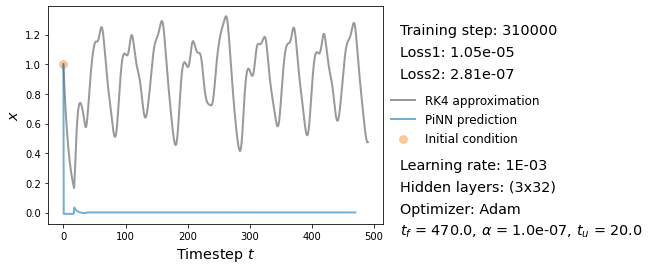

PiNN, iteration: 312500, loss1: 2.0463630789890885e-08, loss2: 1.6471810226903472e-07, time: 1:54:23.348036


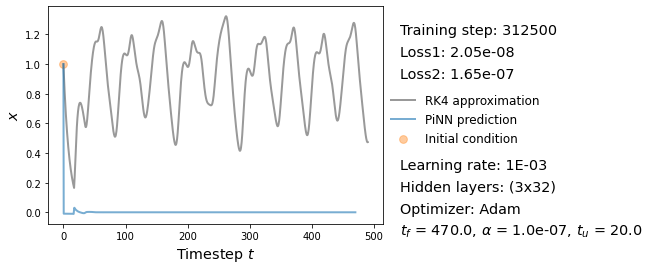

PiNN, iteration: 315000, loss1: 0.0016650757752358913, loss2: 8.159224307746626e-06, time: 1:54:32.436377


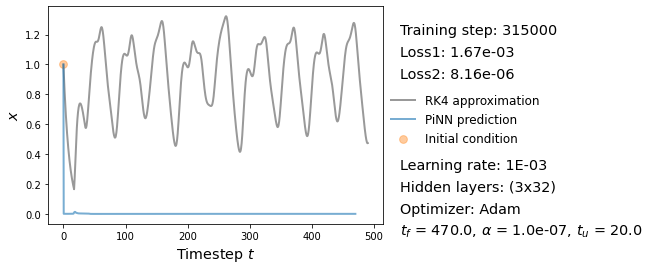

PiNN, iteration: 317500, loss1: 2.217248584202025e-05, loss2: 1.5036184208838677e-07, time: 1:54:41.641338


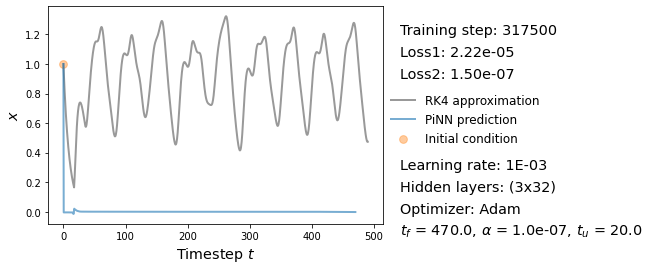

PiNN, iteration: 320000, loss1: 2.377205964876339e-05, loss2: 1.0973556641147297e-07, time: 1:54:50.783786


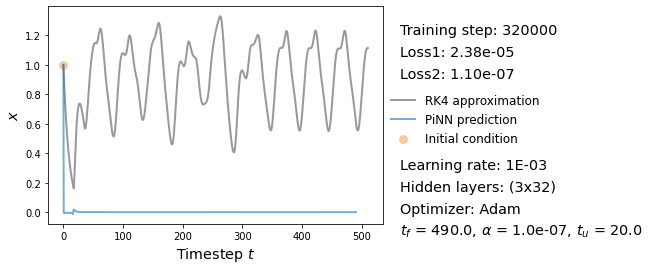

PiNN, iteration: 322500, loss1: 1.770800372469239e-05, loss2: 7.350016772988965e-08, time: 1:55:00.092572


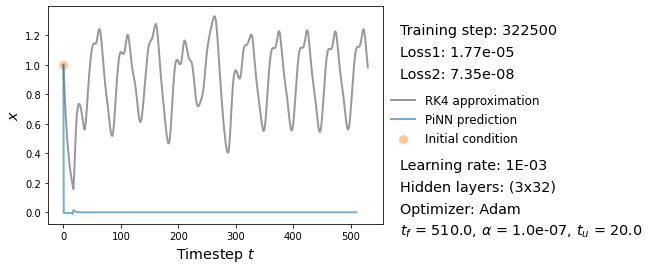

PiNN, iteration: 325000, loss1: 8.881784197001252e-08, loss2: 2.98525826281093e-08, time: 1:55:09.382671


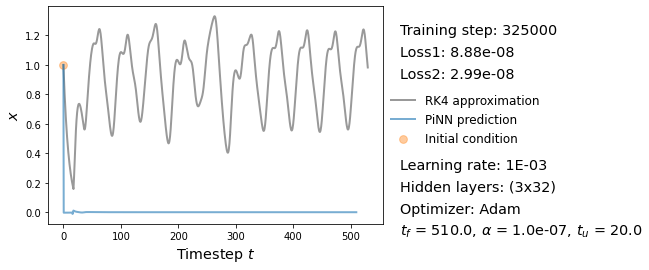

PiNN, iteration: 327500, loss1: 0.000609509414061904, loss2: 4.2980865089248255e-08, time: 1:55:18.826564


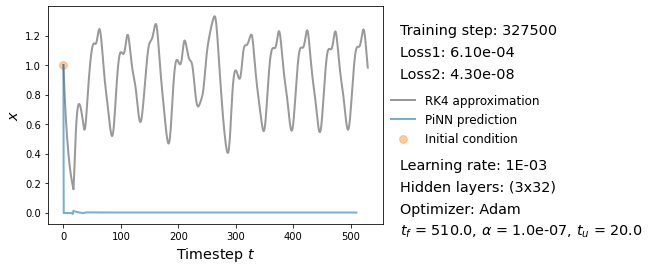

PiNN, iteration: 330000, loss1: 0.0015288605354726315, loss2: 3.090513800430017e-08, time: 1:55:28.120495


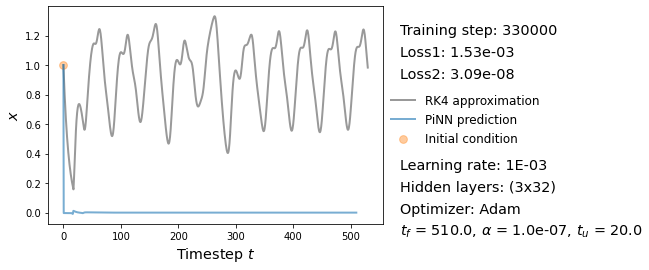

PiNN, iteration: 332500, loss1: 8.185452315956354e-06, loss2: 1.5201138126030855e-08, time: 1:55:37.506033


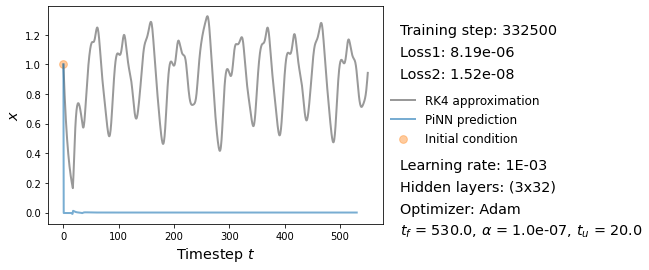

PiNN, iteration: 335000, loss1: 3.783725333050825e-05, loss2: 2.1225593727081105e-08, time: 1:55:46.881757


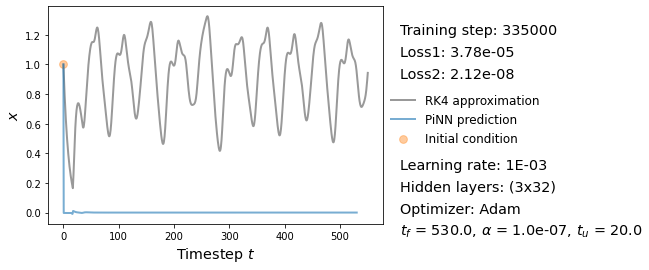

PiNN, iteration: 337500, loss1: 0.0029116906225681305, loss2: 2.5951232274223912e-08, time: 1:55:56.180090


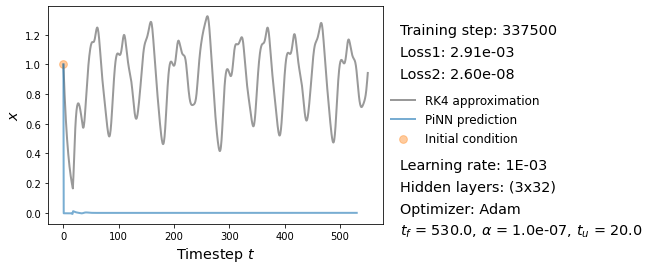

PiNN, iteration: 340000, loss1: 5.115907697472721e-09, loss2: 1.3337258053525147e-07, time: 1:56:05.459768


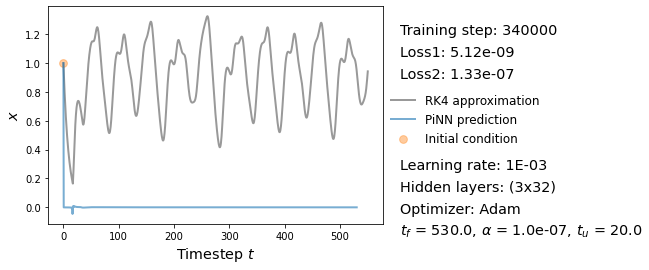

PiNN, iteration: 342500, loss1: 0.0013219647808000445, loss2: 3.3824424150452614e-08, time: 1:56:15.028542


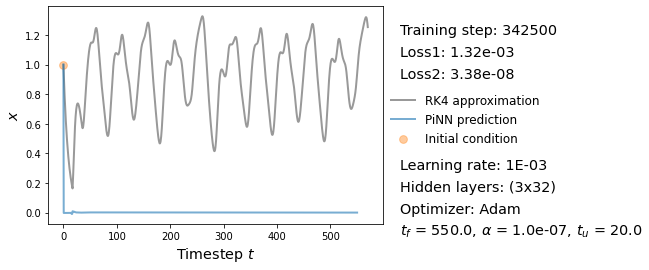

PiNN, iteration: 345000, loss1: 1.2789769243681803e-09, loss2: 1.2129580895248182e-08, time: 1:56:25.453615


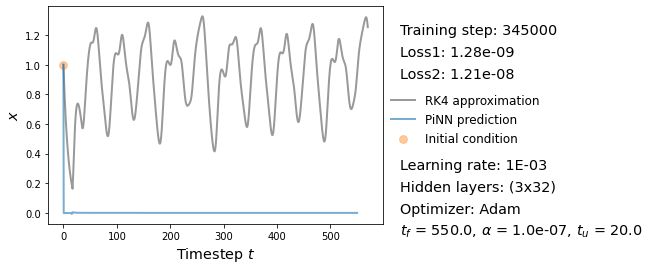

PiNN, iteration: 347500, loss1: 1.2789769243681803e-09, loss2: 1.881216249444151e-08, time: 1:56:35.939784


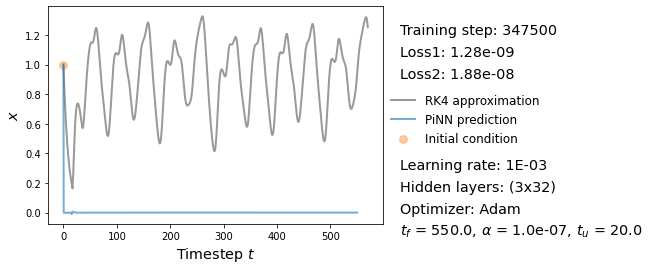

PiNN, iteration: 350000, loss1: 1.1301040103717241e-05, loss2: 3.826399641582157e-09, time: 1:56:45.676044


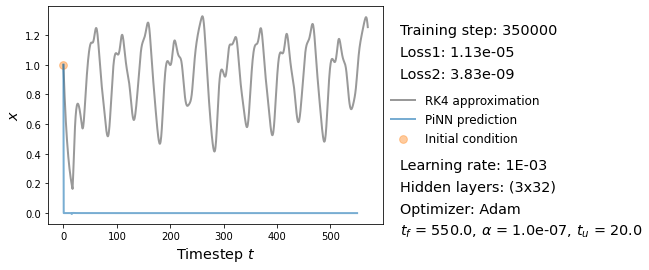

PiNN, iteration: 352500, loss1: 2.220446049250313e-06, loss2: 1.763817039091009e-07, time: 1:56:55.419388


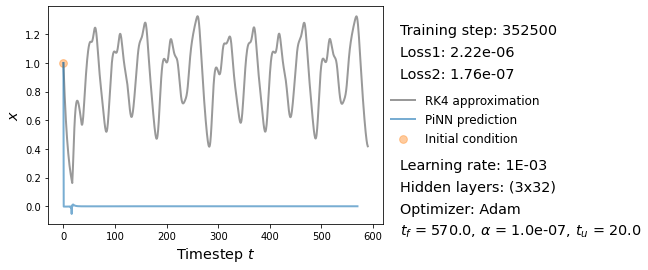

PiNN, iteration: 355000, loss1: 1.4210854715202004e-10, loss2: 9.573582104849265e-08, time: 1:57:05.590721


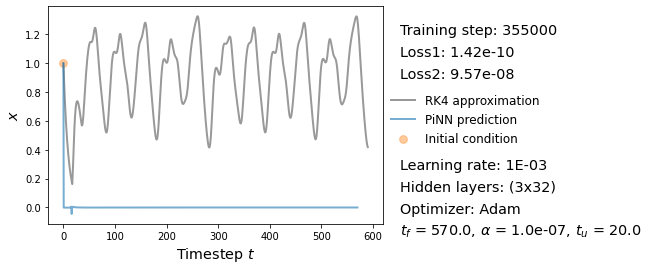

PiNN, iteration: 357500, loss1: 0.0007342079188674688, loss2: 9.59971444558505e-08, time: 1:57:15.657552


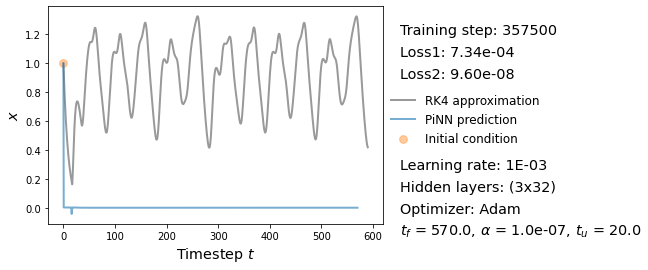

PiNN, iteration: 360000, loss1: 0.001304684323258698, loss2: 9.186445737441318e-08, time: 1:57:25.289862


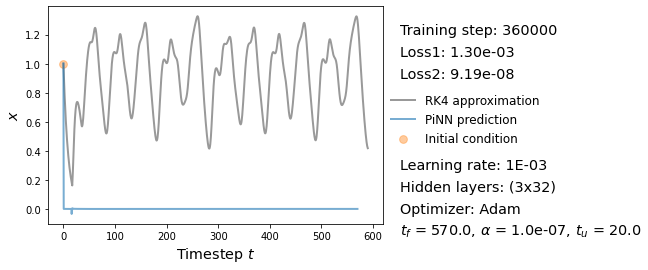

PiNN, iteration: 362500, loss1: 0.0003784953150898218, loss2: 3.4644525470639564e-08, time: 1:57:34.891663


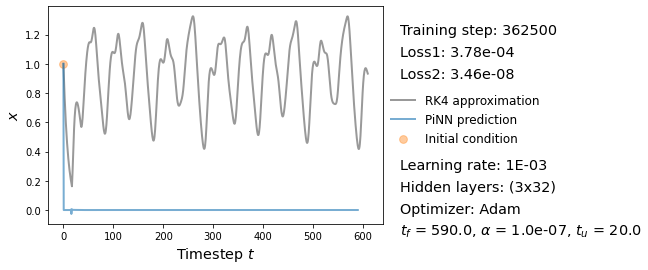

PiNN, iteration: 365000, loss1: 2.0520474208751693e-07, loss2: 5.61338175941728e-08, time: 1:57:45.546874


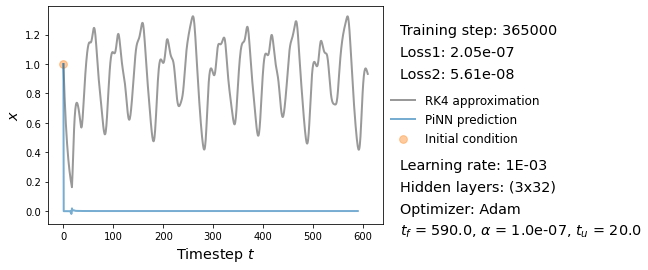

PiNN, iteration: 367500, loss1: 2.4016344468691386e-06, loss2: 3.220236877155003e-08, time: 1:57:56.459199


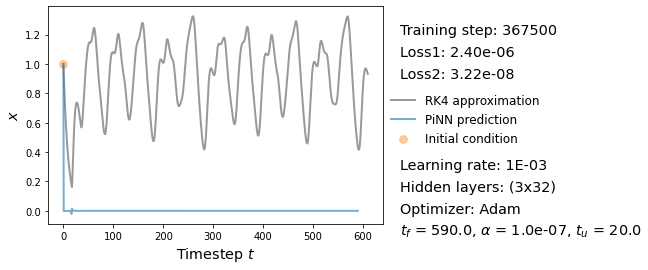

PiNN, iteration: 370000, loss1: 0.004183885175734758, loss2: 3.991620900478665e-08, time: 1:58:05.785615


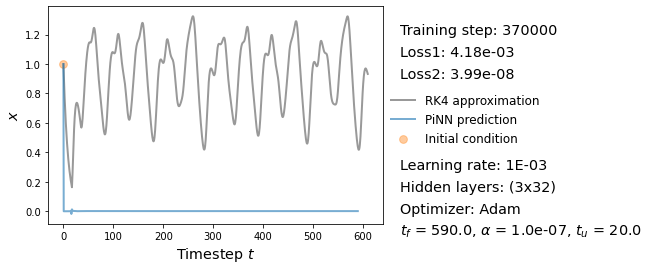

PiNN, iteration: 372500, loss1: 0.00024350029707420617, loss2: 5.989572571252211e-08, time: 1:58:15.094479


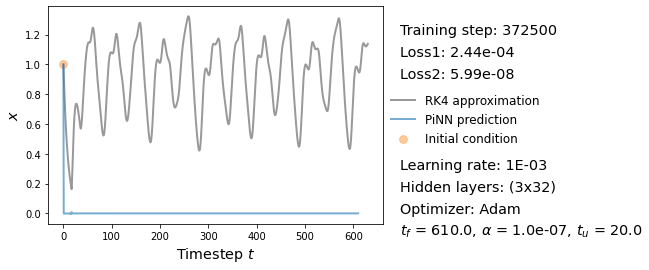

PiNN, iteration: 375000, loss1: 7.948450729600154e-06, loss2: 5.714560380454259e-09, time: 1:58:24.572888


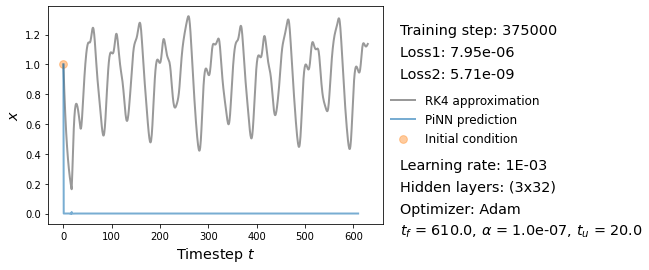

PiNN, iteration: 377500, loss1: 2.2737367544323206e-09, loss2: 4.3145629291529985e-09, time: 1:58:33.840706


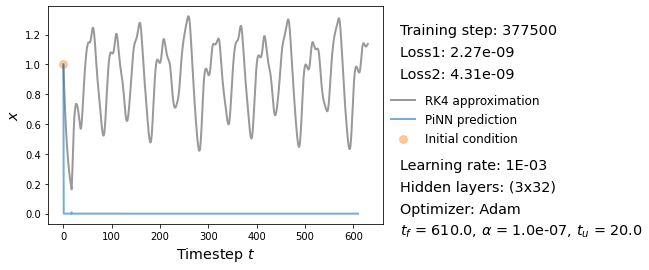

PiNN, iteration: 380000, loss1: 3.552713678800501e-09, loss2: 4.4550780842200766e-09, time: 1:58:43.345916


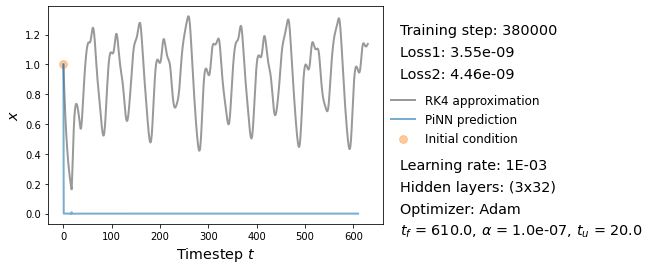

PiNN, iteration: 382500, loss1: 5.972111466689967e-06, loss2: 4.9331001505947825e-09, time: 1:58:52.808740


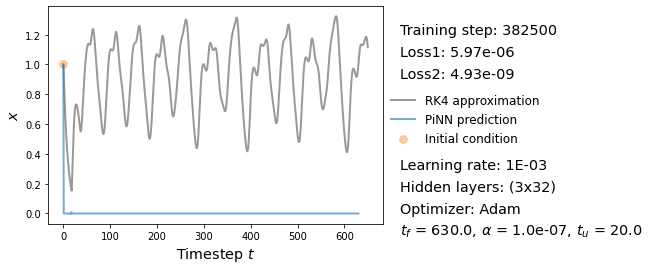

PiNN, iteration: 385000, loss1: 1.4210854715202004e-10, loss2: 2.189050540835069e-08, time: 1:59:01.977053


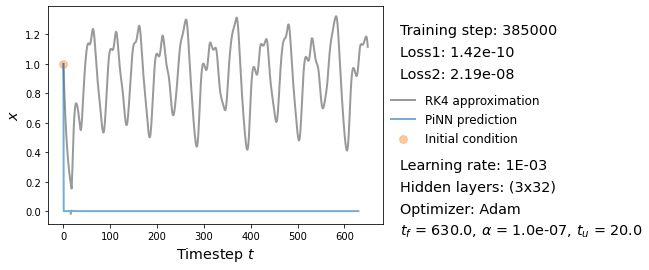

PiNN, iteration: 387500, loss1: 5.445045462693088e-05, loss2: 1.6365977018040212e-08, time: 1:59:11.039044


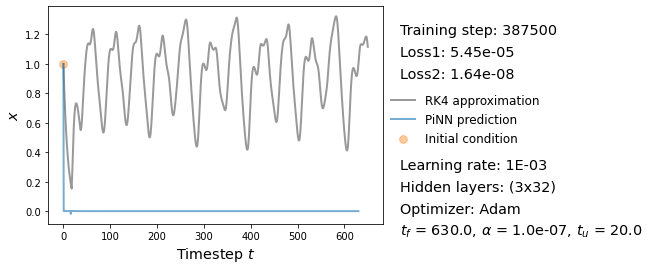

PiNN, iteration: 390000, loss1: 0.0002601451997179538, loss2: 1.4736052378339082e-08, time: 1:59:20.235879


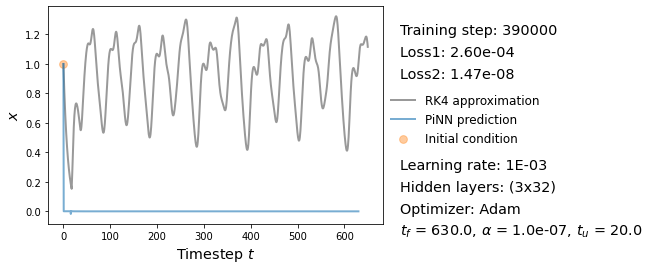

PiNN, iteration: 392500, loss1: 0.0001147245493484661, loss2: 2.747125193991451e-08, time: 1:59:29.522815


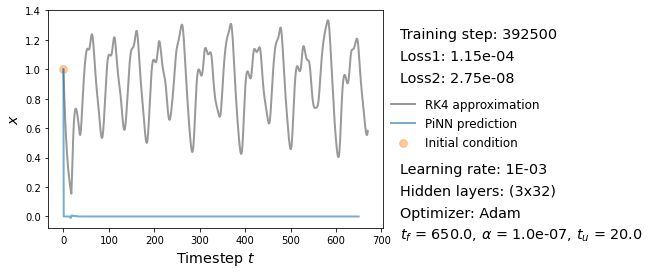

PiNN, iteration: 395000, loss1: 5.9856261941604316e-05, loss2: 2.2389981424453254e-08, time: 1:59:38.859214


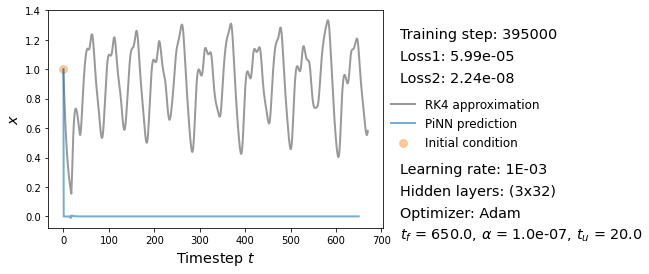

PiNN, iteration: 397500, loss1: 1.5948131704135449e-07, loss2: 2.2648158903848525e-08, time: 1:59:48.220471


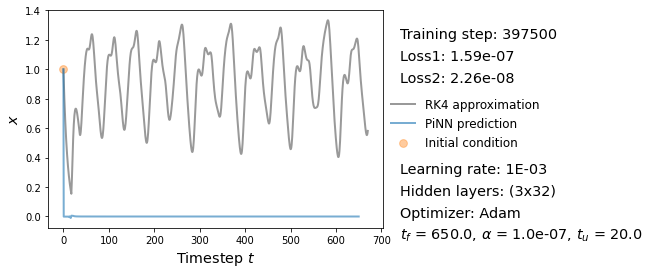

PiNN, iteration: 400000, loss1: 5.721151683246717e-05, loss2: 3.35587380106972e-08, time: 1:59:57.649875


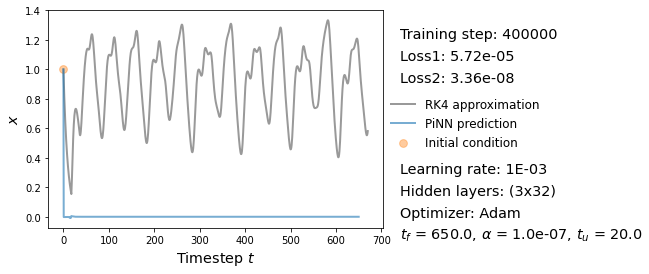

PiNN, iteration: 402500, loss1: 2.3888445866759866e-05, loss2: 1.3428742562382467e-08, time: 2:00:06.889930


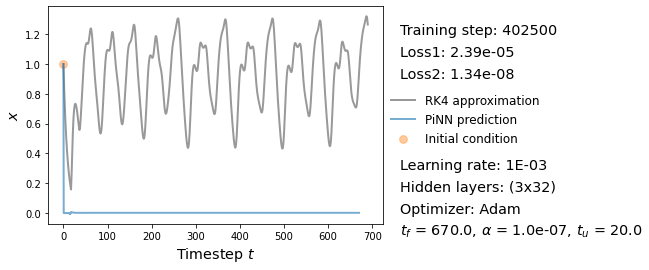

PiNN, iteration: 405000, loss1: 0.002673000330105424, loss2: 1.9316271249181227e-08, time: 2:00:16.124375


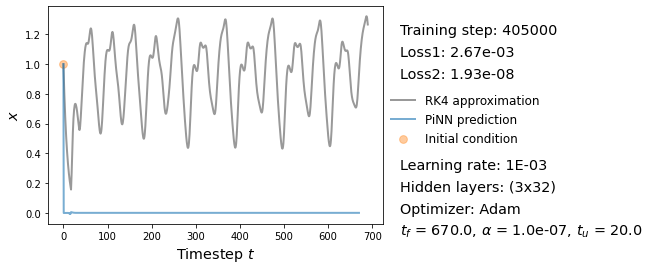

PiNN, iteration: 407500, loss1: 1.4210854715202004e-10, loss2: 5.405101699551551e-09, time: 2:00:25.670794


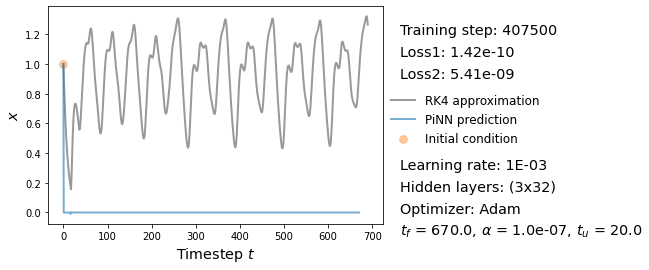

PiNN, iteration: 410000, loss1: 0.0012141653569415212, loss2: 1.2036272423188166e-08, time: 2:00:35.304478


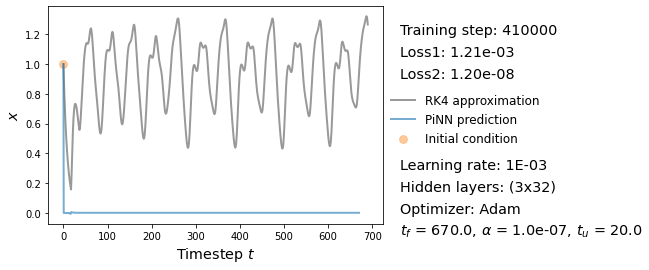

PiNN, iteration: 412500, loss1: 5.784443055745214e-05, loss2: 1.6316684892103694e-08, time: 2:00:45.309180


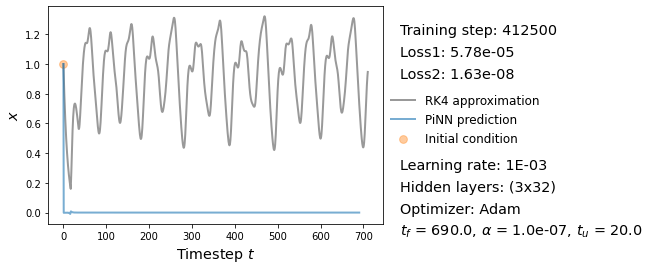

PiNN, iteration: 415000, loss1: 0.0004996003699488938, loss2: 1.3435218271240501e-08, time: 2:00:54.551093


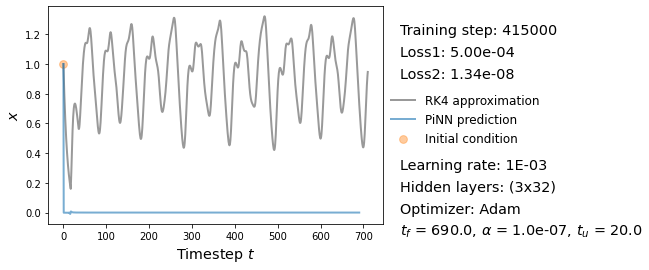

PiNN, iteration: 417500, loss1: 3.552713678800501e-09, loss2: 1.089325962766452e-08, time: 2:01:03.839203


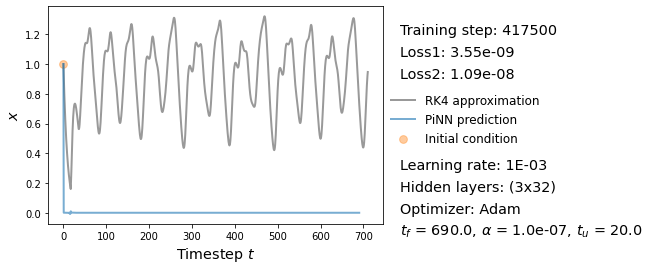

PiNN, iteration: 420000, loss1: 4.298783551348606e-07, loss2: 4.107192363989043e-09, time: 2:01:13.247945


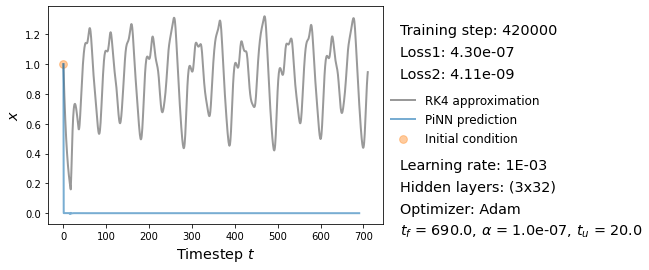

PiNN, iteration: 422500, loss1: 2.447464453325665e-07, loss2: 3.36370686859766e-09, time: 2:01:22.805312


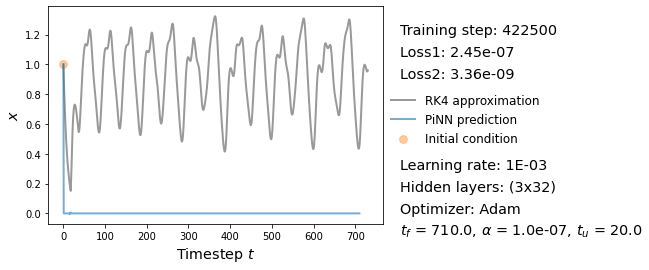

PiNN, iteration: 425000, loss1: 5.130118552187923e-06, loss2: 1.0465611488541526e-08, time: 2:01:32.667745


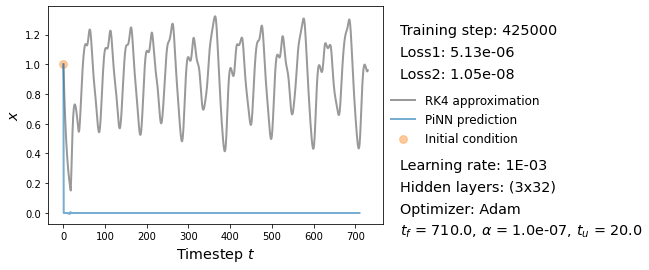

PiNN, iteration: 427500, loss1: 7.8813754953444e-06, loss2: 4.433966971362224e-09, time: 2:01:42.244868


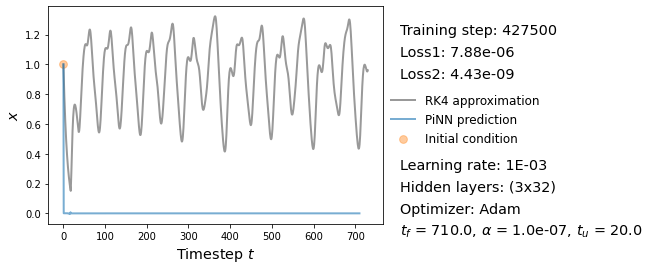

PiNN, iteration: 430000, loss1: 0.0018142045009881258, loss2: 4.340065018482164e-08, time: 2:01:51.493927


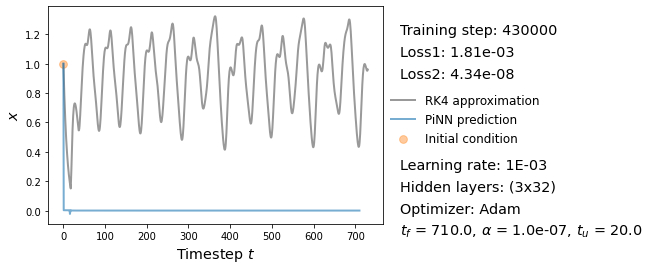

KeyboardInterrupt: ignored

In [33]:
t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

# Define or load the model ----------------------------------------------------
model = FCN(INPUT,OUTPUT,N_HIDDEN,N_LAYERS) #Create a network with the specified settings
# Following is to load an already trained model -------------------------------
# model.load_state_dict(torch.load("PATHNAME.pth"))
# model.eval()

optimizer = torch.optim.Adam(model.parameters(),lr=lr) #Specify the optimizer and use the learning rate
iteration_help_list = [] #Extra prevention for exploding final time, can only update 10.000 iterations after last update
files_x = [] #Create empty files for the intermediate results for the animation
tf_list = [] #Empty file for updating of the final time 
for i in range(iterations): #Loop over the iterations
    optimizer.zero_grad() #Set gradients of all optimized tensors to zero
    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/1000
    # t_np = np.random.uniform(ti,tf,n)        #In the case random final times are used in the training
    # t_physics = torch.FloatTensor(t_np).view(-1,1).requires_grad_(True)
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #t_physics needs to be re-specified

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = model(torch.FloatTensor([0]))
    loss1 = (10e3)*torch.mean((m[0]-x0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    px = model(t_physics)
    if tf < tau:
        px_minus_tau = torch.zeros(n) #Zero when tf - tau < 0
    else:
        px_transpose = px.T
        zero_tensor = torch.zeros(int(n/tf*tau))
        px_minus_tau = torch.cat((zero_tensor, px_transpose[0][:-int(n/tf*tau)]), 0)
    px,px_minus_tau = px.view(-1,1),px_minus_tau.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    loss2 = torch.mean((a*px_minus_tau/(1 + px_minus_tau**10) - b*px - dxdt)**2)

    loss = loss1 + (10e2)*loss2 #Total loss
    # def closure(): return loss        #for LBFGS, also use optimizer.step(closure)
    loss.backward()   #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer.step()  #parameter += -lr * parameter.grad
    
    if (i+1)%intermediate == 0: #Plot and save intermediate results
        t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
        p = model(t_physics)
        print("PiNN, iteration: {}, loss1: {}, loss2: {}, time: {}".format(i+1,loss1,loss2,datetime.now() - time))
        xh = torch.squeeze(p.detach()) #PiNN approximation with:
        th = torch.linspace(ti,tf,n).view(-1,1) #corresponding times
        x = torch.FloatTensor(RungeKutta(MG, x0, float('%.2g'%(tf+20)),n)) #RK4 results with:
        t = torch.linspace(ti,tf+20,n).view(-1,1) #corresponding times that stays +20 timesteps above the PiNN predicted result

        plot2D(t,x,tf, th,xh, x0, "x") #2D (t,x)-plot
        file = "plots_x/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_x.append(file)
        
        plt.show() #Show plots

    if i%10000 == 0: #Extra prevention to avoid exploding final time. Max 1 update per 10.000 iterations
        iteration_help_list.append(i)
    if len(iteration_help_list) > 0:
        if loss2 < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
            tf_list.append(tf + update_t)
            iteration_help_list = []

torch.save(model.state_dict(), 'MG_model_weights_{}.pth'.format(iterations))

#Creating gif-animations:
save_gif("pinn_x.gif", files_x, fps=20, loop=0)